# **Introduction**

Strategies for dealing with missing data are a necessary component of the analysis of any new dataset. In most cases, rather than removing records containing missing values, the preferred method is making an educated guess as to what the missing value might be and imputing the datapoint with a best guess estimate. Imputation is a method that preserves the useful data present within a dataset, while providing machine learning algorithms with the complete data they demand.

Like any other phenomena, missing data follows predictable patterns. The imputation strategy that the analyst applies should take into account why the data is missing. To accurately identify the latent patterns causing missing data, the analyst must carefully observe the data that is present for patterns. Data can be missing at random, missing not at random, and missing completely at random. While these categories appear to be very similar, knowing the differences in the patterns they describe can make the difference that leads to a high performing model. 

# **Types of Missing Data**

A commonly occuring kind of "missingness" is data that is missing at random. When missing data occur randomly, without a noticeable pattern, but the missing data can be modeled, then they are considered missing at random. The existing data can be used to fit a model that predicts what these values may be. 

Data that is missing not at random means that the probability of "missingness" is not random, but is not known. An example of this phenomenon is missing data due to a sensor wearing out over time. We may not have a model that accurately predicts when missing data will occur, but we do know that it will occur.

Data that is missing completely at random is a less common occurance. All data points have an equal probability of "missingness", which cannot be predicted, and the cause of the missingness is unknown. An example of data that is missing completely at random are data not inlcuded in the random sample of a population. 

# **The Dataset**
The dataset is composed of over 30,471 Russian home prices with 292 continuous and categorical features to inform home price predictions. Approximately 47% of the entire dataset is missing data, distributed over 51 columns. Missing datapoints are either missing at random or missing not at random.

# **Imputation Methods**

Given that the focus of this study is on imputation methods, we will not delete records from the dataset. Instead, we will explore the dataset for patterns that allow us to interpolate the missing data we observe. The primary means of imputing the data will be univariate inference and Scikit-Learn implementations of a KNN imputation approach and the Iterative Imputation\footnotemark.

\footnotetext{https://scikit-learn.org/stable/modules/impute.html}



# **Data Imputation**

**intro paragraph**

Introduce the missing values, maybe a table of them?

Then do sections on the imputation for each variable or groups of variables

### **Cafe Variables**

A set of variables related to cafe prices are missing values.
The variables, `cafe_sum_X_min_price_avg`, `cafe_sum_X_max_price_avg`, and `cafe_avg_price_X`, represent the minimum, maximum, and average cafe bills in a given `X` radius.
As shown in Fig. X, these variables are highly correlated for any given radius.
Since these variables are highly correlated, we will drop the minimum and maximum columns and keep only the average price column, namely `cafe_avg_price_X`.

![cafe_pair_plot](./images/cafe_sum_500_X_pairplot.png)



Figure X: Pair plot of cafe_sum_500_min_price_avg, cafe_sum_500_max_price_avg, and cafe_avg_price_500.
These variables are strongly correlated.
The other similar cafe variables exhibit similar behavior.


There is also a set related complete columns `cafe_count_X`, which provide a count of the cafes in the given radius `X`.
Most of the `cafe_avg_price_X` values are missing when `cafe_count_X==0`, which is sensible.
We will set `cafe_avg_price_X` to `-1` when `cafe_count_X==0` as a numeric indication that `cafe_avg_price_X` is missing.
However, there are missing values present when `cafe_count_X` is not equal to `0`.
The missingness of `cafe_count_X` appears to be related to `sub area` and `cafe_count_X`.
Fig. Y shows that the missingness of `cafe_avg_price_500` is related to `sub_area` and `cafe_count_500`.
The other similar variables exhibit similar behavior.
There does not appear to be a pattern beyond this relationship.

![heatmap](./images/cafe_500_heatmap.png)


Figure Y: Heatmap of missing count of cafe_avg_price_500 by sub_area and cafe_count_500 (sub_area is indexed). 
The missingness of cafe_avg_price_500 appears to depend on both sub_area and cafe_count_500.


We used the median value to impute these values.
The distributions of `cafe_avg_price_X` variables appear to be irregular as shown in Fig. Z.
The imputation strategy was as follows:

* For each `cafe_count_X`:
  * If `cafe_count_X==0`, set `cafe_avg_price_X` to -1 to indicate a null value
  * If `cafe_count_X > 0` and all values of `cafe_avg_price_X` are missing, set `cafe_avg_price_X` to `-1` to indicate null values
  * Else, use median of `cafe_avg_price_X` values corresponding to the levels of `cafe_count_X` and levels of `sub_area`

![cafe distributions](./images/distributions_of_caf_avg_price_col.png)


Figure Z: Distributions of several cafe_avg_price_X variables by cafe_count_X


# Modeling

Something on modeling, what model, tuning, etc.

# Results

Whatever we have for results, I guess the model

# Conclusions

# Appendix

In [69]:
from collections import defaultdict

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

random_state = 42

In [3]:
df = pd.read_csv('./data/train.csv')
df.shape

(30471, 292)

In [23]:
names = df.columns
names[10:30]

Index(['state', 'product_type', 'sub_area', 'area_m', 'raion_popul',
       'green_zone_part', 'indust_part', 'children_preschool',
       'preschool_quota', 'preschool_education_centers_raion',
       'children_school', 'school_quota', 'school_education_centers_raion',
       'school_education_centers_top_20_raion', 'hospital_beds_raion',
       'healthcare_centers_raion', 'university_top_20_raion',
       'sport_objects_raion', 'additional_education_raion',
       'culture_objects_top_25'],
      dtype='object')

#### First, get list of all records with missing values. See if we can drop them all
#### Recognized there are no records without missing information
#### Next, if we can drop them all, we can run random forest to see which features are most important.
#### Finally, we can impute in order of importance; for most important features, we will impute them first, then work downward.

In [24]:
df.shape

(30471, 292)

## A count of all missing values

In [89]:
nullList = df.isnull().sum()
na_list=nullList[nullList>0].sort_values(ascending=False)

In [26]:
print('Count of columns with missing values: {}\nCount of columns without missing values: {}'.format(nullList[nullList>0].sort_values(ascending=False).count(), nullList[nullList==0].sort_values(ascending=False).count()))

Count of columns with missing values: 51
Count of columns without missing values: 241


In [27]:
print('Percent of dataset records with null values: {}%'.format(round(nullList[nullList>0].max()/df.shape[0]*100, 2)))

Percent of dataset records with null values: 47.39%


### A dataframe of missing values and their data types for selecting imputation algorithm

### We're assuming not every neighborhood in Moscow has a hospital, just as not every neighborhood in Dallas has a hospital.

In [90]:
df_missing = pd.DataFrame(list(zip(na_list.index, na_list.values)), columns=['feature','na_count'])
df_dtypes = pd.DataFrame(list(zip(df.dtypes.index, df.dtypes)), columns=['feature','type'])
df_missing.merge(df_dtypes, how='inner', on='feature')

feature  na_count     type
0                     hospital_beds_raion     14441  float64
1                              build_year     13605  float64
2                                   state     13559  float64
3              cafe_sum_500_min_price_avg     13281  float64
4              cafe_sum_500_max_price_avg     13281  float64
5                      cafe_avg_price_500     13281  float64
6                               max_floor      9572  float64
7                                material      9572  float64
8                                num_room      9572  float64
9                                kitch_sq      9572  float64
10                        preschool_quota      6688  float64
11                           school_quota      6685  float64
12            cafe_sum_1000_max_price_avg      6524  float64
13            cafe_sum_1000_min_price_avg      6524  float64
14                    cafe_avg_price_1000      6524  float64
15                                life_sq      6383  float64
16                build_count_before_1920      4991  float64
17                      build_count_block      4991  float64
18   raion_build_count_with_material_info      4991  float64
19                       build_count_wood      4991  float64
20                      build_count_frame      4991  float64
21                      build_count_brick      4991  float64
22                   build_count_monolith      4991  float64
23                      build_count_panel      4991  float64
24                       build_count_foam      4991  float64
25                       build_count_slag      4991  float64
26                        build_count_mix      4991  float64
27  raion_build_count_with_builddate_info      4991  float64
28                  build_count_1971-1995      4991  float64
29                  build_count_1921-1945      4991  float64
30                  build_count_1946-1970      4991  float64
31                 build_count_after_1995      4991  float64
32            cafe_sum_1500_min_price_avg      4199  float64
33            cafe_sum_1500_max_price_avg      4199  float64
34                    cafe_avg_price_1500      4199  float64
35            cafe_sum_2000_min_price_avg      1725  float64
36            cafe_sum_2000_max_price_avg      1725  float64
37                    cafe_avg_price_2000      1725  float64
38            cafe_sum_3000_min_price_avg       991  float64
39            cafe_sum_3000_max_price_avg       991  float64
40                    cafe_avg_price_3000       991  float64
41            cafe_sum_5000_max_price_avg       297  float64
42            cafe_sum_5000_min_price_avg       297  float64
43                    cafe_avg_price_5000       297  float64
44                         prom_part_5000       178  float64
45                                  floor       167  float64
46               railroad_station_walk_km        25  float64
47              railroad_station_walk_min        25  float64
48               ID_railroad_station_walk        25  float64
49                          metro_km_walk        25  float64
50                         metro_min_walk        25  float64

In [91]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [93]:
df_cats = df.select_dtypes(include=['O'])

In [94]:
df_cats2 = df_cats.drop('timestamp',axis=1)

In [96]:
print('Categorical cardinality:\n\nFeature product_type:\n{}\n\nFeature ecology:\n{}\n\nFeature sub_area:\n{}'.format(df_cats['product_type'].unique(), df_cats['ecology'].unique(), df_cats['sub_area'].unique()))

Categorical cardinality:

Feature product_type:
['Investment' 'OwnerOccupier']

Feature ecology:
['good' 'excellent' 'poor' 'satisfactory' 'no data']

Feature sub_area:
['Bibirevo' 'Nagatinskij Zaton' "Tekstil'shhiki" 'Mitino' 'Basmannoe'
 'Nizhegorodskoe' "Sokol'niki" 'Koptevo' 'Kuncevo' 'Kosino-Uhtomskoe'
 'Zapadnoe Degunino' 'Presnenskoe' 'Lefortovo' "Mar'ino" "Kuz'minki"
 'Nagornoe' "Gol'janovo" 'Vnukovo' 'Juzhnoe Tushino' 'Severnoe Tushino'
 "Chertanovo Central'noe" 'Fili Davydkovo' 'Otradnoe' 'Novo-Peredelkino'
 'Bogorodskoe' 'Jaroslavskoe' 'Strogino' 'Hovrino' "Moskvorech'e-Saburovo"
 'Staroe Krjukovo' 'Ljublino' 'Caricyno' 'Veshnjaki' 'Danilovskoe'
 'Preobrazhenskoe' "Kon'kovo" 'Brateevo' 'Vostochnoe Izmajlovo'
 'Vyhino-Zhulebino' 'Donskoe' 'Novogireevo' 'Juzhnoe Butovo' 'Sokol'
 'Kurkino' 'Izmajlovo' 'Severnoe Medvedkovo' 'Rostokino'
 'Orehovo-Borisovo Severnoe' 'Ochakovo-Matveevskoe' 'Taganskoe'
 'Dmitrovskoe' 'Orehovo-Borisovo Juzhnoe' 'Teplyj Stan' 'Babushkinskoe'
 'Pokrovs

In [97]:
df_cats2['sub_area'].isnull().sum()

0

# One-hot and label encode

In [98]:
sub_area = df_cats2['sub_area'].astype('category')
one_hots = df_cats2.drop('sub_area',axis=1)
sub_area_final = sub_area.cat.codes
one_hots_final = pd.get_dummies(one_hots)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sub_area.cat.codes)

In [100]:
sub_area.isna().sum()

0

In [101]:
encodes = pd.concat([sub_area_final,one_hots_final], axis=1).astype('int64')

# Get a list of the non-null values and run a model to predict price_doc
## Concatenate with encoded variables

In [102]:
print('time range: [{}, {}]'.format(df['timestamp'].min(),df['timestamp'].max()))

time range: [2011-08-20, 2015-06-30]


In [103]:
nullList = df.isnull().sum()
non_naList=nullList[nullList==0].sort_values(ascending=False)
non_null_features = list(non_naList.index)

In [104]:
df[non_null_features].dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [105]:
no_null_df = df[non_null_features].drop(['id','timestamp'], axis=1).select_dtypes(include=['int64','float64'])

In [106]:
df_no_null = pd.concat([no_null_df, encodes], axis=1)

In [107]:
df_no_null.head()

price_doc  catering_km  zd_vokzaly_avto_km  railroad_km  ID_big_road2  \
0    5850000     0.516838           14.231961     1.305159             5   
1    6000000     0.230287            9.242586     0.694536             4   
2    5700000     0.190462            9.540544     0.700691             4   
3   13100000     0.465820           17.478380     1.999265            17   
4   16331452     0.026102            1.595898     0.084113            10   

   big_road2_km  ID_big_road1  big_road1_km  kremlin_km  bulvar_ring_km  ...  \
0      3.830951             1      1.422391   15.156211       13.675657  ...   
1      3.103996             2      2.887377    8.698054        8.132640  ...   
2      2.927487             3      0.647250    9.067885        8.054252  ...   
3      2.780449             1      2.677824   19.487005       18.309433  ...   
4      3.133531             4      1.721834    2.578671        0.787593  ...   

   water_1line_yes  big_road1_1line_no  big_road1_1line_yes  \
0                0                   1                    0   
1                0                   1                    0   
2                0                   1                    0   
3                0                   1                    0   
4                0                   1                    0   

   railroad_1line_no  railroad_1line_yes  ecology_excellent  ecology_good  \
0                  1                   0                  0             1   
1                  1                   0                  1             0   
2                  1                   0                  0             0   
3                  1                   0                  0             1   
4                  0                   1                  1             0   

   ecology_no data  ecology_poor  ecology_satisfactory  
0                0             0                     0  
1                0             0                     0  
2                0             1                     0  
3                0             0                     0  
4                0             0                     0  

[5 rows x 256 columns]

## Correlation matrix including encoded categorical data

In [44]:
# Compute the correlation matrix
corr = df_no_null.corr()

## Correlation matrix excluding categorical data

# There is no strong correlation in the dataset when there are only columns that do not contain NA

In [ ]:
#pd.set_option('display.max_columns', None)
#corr

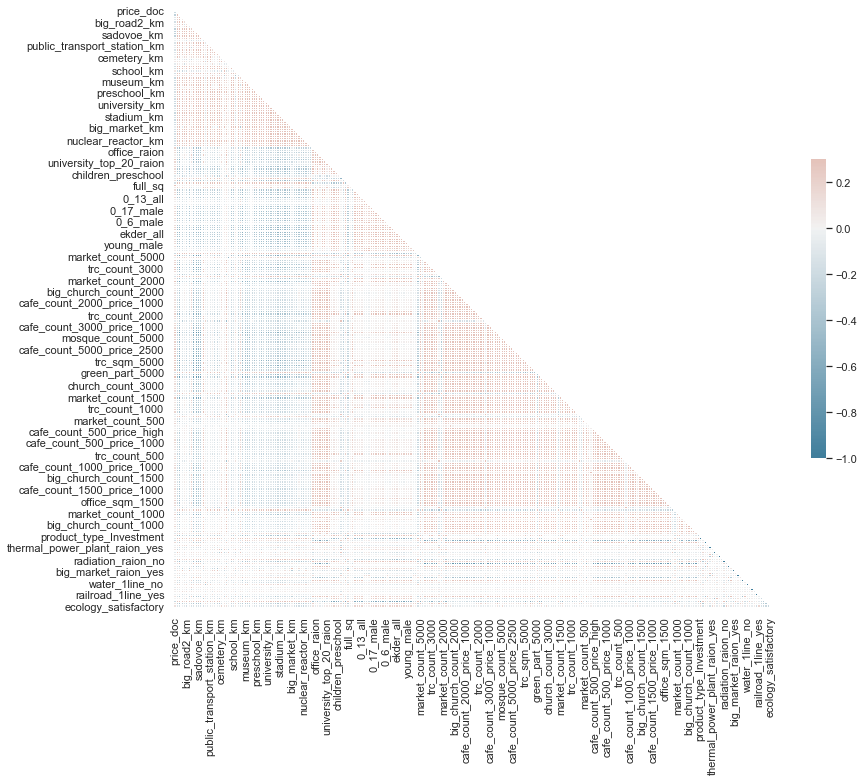

In [108]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

## PCA
There're a lot of variables, so we can apply PCA to help us visualize their importance

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_no_null_scaled = scaler.fit_transform(df_no_null)
no_null_df_scaled = scaler.fit_transform(no_null_df)

pca = PCA(n_components=2)

df_no_null_reduced = pca.fit_transform(df_no_null_scaled)
no_null_df_reduced = pca.fit_transform(no_null_df)

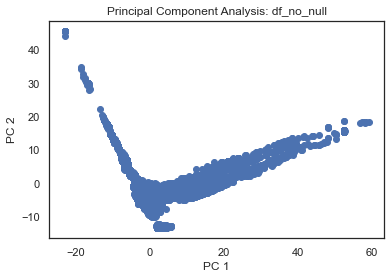

In [53]:
plt.scatter(df_no_null_reduced[:,0], df_no_null_reduced[:,1])
plt.title('Principal Component Analysis: df_no_null')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [54]:
pca = PCA(n_components=2)

df_no_null_reduced = pca.fit_transform(df_no_null_scaled)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 60)
ax = sns.heatmap(pca.components_.T,
                 cmap='coolwarm',
                 xticklabels=['PC ' + str(x) for x in range(1,pca.n_components_+1)],
                 yticklabels=list(no_null_df.columns)
                 )

# Running a linear regression on price_doc to assess model performance without variables having missing values. This will be compared again after imputing

In [109]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = df_no_null['price_doc']
X = df_no_null.drop(['price_doc'], axis=1)
normalized_X = preprocessing.normalize(X)
X_normalized = pd.DataFrame(normalized_X, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.33, random_state=42)

In [110]:
regress = linear_model.LinearRegression()
regress.fit(X_train, y_train)
y_preds = regress.predict(X_test)
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_preds)))

Mean Squared Error: 12620102689942.143


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# set a random seed for reproducibility
random_seed = 42
# define the estimator
linearRegress = LinearRegression()
# provide the parameters of the feature selection process
feature_selector = RFECV(linearRegress,
          step = 1,
          min_features_to_select= 1,
          cv = 5,
          n_jobs = -1) 
# create an 80:20 train:test set split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = random_seed, test_size = .20)
print('X_train shape: ', X_train.shape, '\ny_train shape: ', y_train.shape, 
      '\nX_test shape: ', X_test.shape, '\ny_test shape: ', y_test.shape)

In [ ]:
# fit the selector to the training set 
feature_selector = feature_selector.fit(X_train, y_train)

In [ ]:
# visualize the results
print('Optimal number of features : %d' % feature_selector.n_features_)
plt.figure()
plt.xlabel('Number of features Selected')
plt.ylabel('Cross validation score')
plt.plot(range(1,len(feature_selector.grid_scores_) +1), feature_selector.grid_scores_)
plt.show()

In [ ]:
df_no_null.columns[116]

In [ ]:
plt.hist(df_no_null['sport_count_2000'], bins = 50);

In [ ]:
df_no_sport = df_no_null.drop('sport_count_2000', axis = 1)
feature_selector = feature_selector.fit(X_train, y_train)
# visualize the results
print('Optimal number of features : %d' % feature_selector.n_features_)
plt.figure()
plt.xlabel('Number of features Selected')
plt.ylabel('Cross validation score')
plt.plot(range(1,len(feature_selector.grid_scores_) +1), feature_selector.grid_scores_)
plt.show()

### Using Ordinary Least Squares to check out serial correlation and feature importance relative to price_doc (y)

In [111]:
import statsmodels.api as sm
X2 = sm.add_constant(X_normalized)
est = sm.OLS(y, X2)
est2 = est.fit()
#est2.summary(alpha=0.05)

### Durbin-Watson test statistic using lag-1 horizons indicate - with a value almost equal to 2 - that there is a very minimal risk of serial correlation. Therefore, a time series model is not required.

In [112]:
import statsmodels
resids = y_test-y_preds
print('Durbin-Watson test for serial correlation (lag-1 auto-correlation): {}'.format(round(statsmodels.stats.stattools.durbin_watson(resids, axis=0),3)))

Durbin-Watson test for serial correlation (lag-1 auto-correlation): 1.978


### A low adjusted r-squared indicates there is too much multi-collinearity in the data and the right features may not be included. Therefore, imputation is necessary.

In [62]:
print('Adjusted R-Square: {}'.format(round(est2.rsquared_adj, 3)))

Adjusted R-Square: 0.377


### The very low value of the smallest eigenvalue also indicates strong multi-collinearity by suggesting the matrix is close to singular

In [63]:
est2.eigenvals.min()

3.042230987622032e-28

In [64]:
print('Percent of features that are statistically significant: {}%'.format(round(est2.pvalues[est2.pvalues < 0.05].count() / est2.pvalues.count()*100, 2)))

Percent of features that are statistically significant: 49.61%


In [113]:
pval_names = list(est2.pvalues[est2.pvalues < 0.05].index)
pvals = list(est2.pvalues[est2.pvalues < 0.05].values)

In [114]:
stat_sig = pd.DataFrame(list(zip(pval_names, pvals)), columns=['feature','p-value'])
stat_sig.sort_values(by='p-value').reset_index(drop=True).head()

feature       p-value
0                     full_sq  0.000000e+00
1   culture_objects_top_25_no  4.221515e-13
2  culture_objects_top_25_yes  9.667293e-12
3          leisure_count_1500  1.282035e-11
4  cafe_count_3000_price_1000  3.677676e-11

After running a linear regression on the data without imputing any values and only using columns that do not have missing information, we have high error and cannot use this method to impute. Because of the high cardinality, we cannot treat the feature as categorical and apply a classification algorithm. Therefore, we impute with zero under the assumption not all sub_areas (neighborhoods) have hospitals. Furthermore, there are no splits on sub_areas; all sub_areas either have hospital bed counts or they do not, but there are no sub_areas that have randomly missing values.

## Hospital_bed_raion

In [67]:
print('Percent of hospital_beds_raion with missing values: {}%'.format(round(100*df['hospital_beds_raion'].isna().sum()/df.shape[0],2)))

Percent of hospital_beds_raion with missing values: 47.39%


In [115]:
neighborhoods = pd.concat([df['sub_area'],df['hospital_beds_raion']], axis=1)
s = neighborhoods.groupby(neighborhoods['sub_area']).sum()

#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
s.sort_values(by='sub_area', ascending=True).head() # Missing values appear as 0

hospital_beds_raion
sub_area                           
Ajeroport                  125460.0
Akademicheskoe             175130.0
Alekseevskoe                77000.0
Altuf'evskoe                    0.0
Arbat                        8430.0

### Hospital bed imputation
Because missing values for hospital_beds_raion are missing not at random - meaning neighborhoods that have values have values across all records whereas neighborhoods that do not have values have no values across all records - we will impute missing values for hospital_beds_raion with value zero.

In [116]:
df.loc[df['hospital_beds_raion'].isna(),'hospital_beds_raion'] = 0

In [117]:
df1 = pd.concat([df_no_null, df['hospital_beds_raion']], axis=1)

## Build Year
For this, we used an ensemble of a linear regression using all numeric features not containing NA and the median by sub_area for imputing build year. Mean squared error outperformed model baseline used to predict price_doc so using linear regression to impute for an input variable will not likely make the model worse.

In [118]:
# sub_area = df_cats2['sub_area'].astype('category')
# one_hots = df_cats2.drop('sub_area',axis=1)
# sub_area_final = sub_area.cat.codes
# one_hots_final = pd.get_dummies(one_hots)

# encodes = pd.concat([sub_area_final,one_hots_final], axis=1).astype('int64')

# nullList = df.isnull().sum()
# non_naList=nullList[nullList==0].sort_values(ascending=False)
# non_null_features = list(non_naList.index)

# no_null_df = df[non_null_features].drop(['id','timestamp'], axis=1).select_dtypes(include=['int64','float64'])
# df_no_null = pd.concat([no_null_df, encodes], axis=1)
# Concat original non-null dataset with newly imputed hospital beds and the build_year column from df with nulls
df2 = pd.concat([df_no_null.select_dtypes(include=['int64','float64']), df['hospital_beds_raion'], df['build_year']], axis=1)

In [120]:
build_year_df = df2.loc[df2['build_year'].notnull(),:]
build_year_X = build_year_df.drop('build_year', axis=1)
build_year_y = build_year_df['build_year']
normalized_X = preprocessing.normalize(build_year_X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, build_year_y, test_size=0.33, random_state=42)
build_yr_regression = linear_model.LinearRegression()
build_yr_regression.fit(X_train, y_train)
y_preds = build_yr_regression.predict(X_test)
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_preds)))

Mean Squared Error: 1443484330.4020734


In [122]:
build_year_null_df = df2.loc[df2['build_year'].isnull(),:]
build_year_null_X = build_year_df.drop('build_year', axis=1)
build_year_null_y = build_year_df['build_year']
normalized_null_bldyr_X = preprocessing.normalize(build_year_null_X)

In [123]:
regress_imputed_bldyr = build_yr_regression.predict(normalized_null_bldyr_X)

Regression did not do well for imputing build year. Predicted values using the full numeric dataset resulted in predictions that houses were constructed in 43,737 BC (example 1):

In [124]:
regress_imputed_bldyr[0]

-43737.2698629079

### Median Imputation
To impute with median build_year, we needed to first eliminate the NA and outlier values. For this, we identified that years 0 and 20052009 existed in the dataset. We considered those to be the same as missing as well and dropped them from the dataset. We considered taking the average of 2005 and 2009 for the points with 20052009, but we decided it would be simpler to just impute over this value.

In [125]:
df2 = pd.concat([df_no_null.select_dtypes(include=['int64','float64']), df['hospital_beds_raion'], df['build_year'], df['sub_area']], axis=1)

In [126]:
# Take all data where build_year is not null
build_df = df2.loc[df2['build_year'].notna(),:]

In [127]:
from math import floor
print('Mean build year: {}\nMedian build year: {}'.format(floor(build_df['build_year'].mean()), floor(build_df['build_year'].median())))
print('\nMinimum build year: {}\nMaximum build year: {}'.format(floor(build_df['build_year'].min()), floor(build_df['build_year'].max())))

Mean build year: 3068
Median build year: 1979

Minimum build year: 0
Maximum build year: 20052009


In [129]:
build_df_final = build_df.loc[build_df['build_year'].between(1500, 2020),:]

In [130]:
build_year_X = build_df_final.drop(['build_year','sub_area'], axis=1)
build_year_y = build_df_final['build_year']
normalized_X = preprocessing.normalize(build_year_X)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, build_year_y, test_size=0.33, random_state=42)
build_yr_regression = linear_model.LinearRegression()
build_yr_regression.fit(X_train, y_train)
y_preds = build_yr_regression.predict(X_test)
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_preds)))

Mean Squared Error: 202.24245785041163


In [131]:
build_year_null_df = df2.loc[df2['build_year'].isnull(),:]
build_year_null_X = build_year_df.drop('build_year', axis=1)
build_year_null_y = build_year_df['build_year']
normalized_null_bldyr_X = preprocessing.normalize(build_year_null_X)

In [132]:
regress_imputed_bldyr = build_yr_regression.predict(normalized_null_bldyr_X)

In [133]:
regress_imputed_bldyr.max()

2079.3286229585665

First, we assessed the practicality of imputing with the median. We took a distribution of build_years across all neighborhoods and identified a tightly distributed range of build years.

In [134]:
from math import floor
print('Mean build year: {}\nMedian build year: {}'.format(floor(build_df_final['build_year'].mean()), floor(build_df_final['build_year'].median())))
print('\nMinimum build year: {}\nMaximum build year: {}'.format(floor(build_df_final['build_year'].min()), floor(build_df_final['build_year'].max())))

Mean build year: 1985
Median build year: 1981

Minimum build year: 1691
Maximum build year: 2018


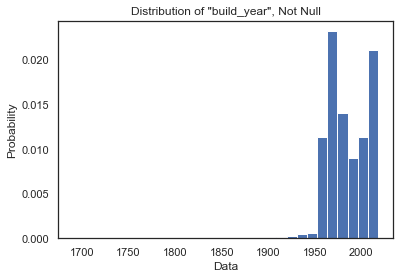

In [135]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
, figsize=(13,10)
np.random.seed(42)
plt.hist(build_df_final['build_year'], density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');
plt.title('Distribution of "build_year", Not Null');

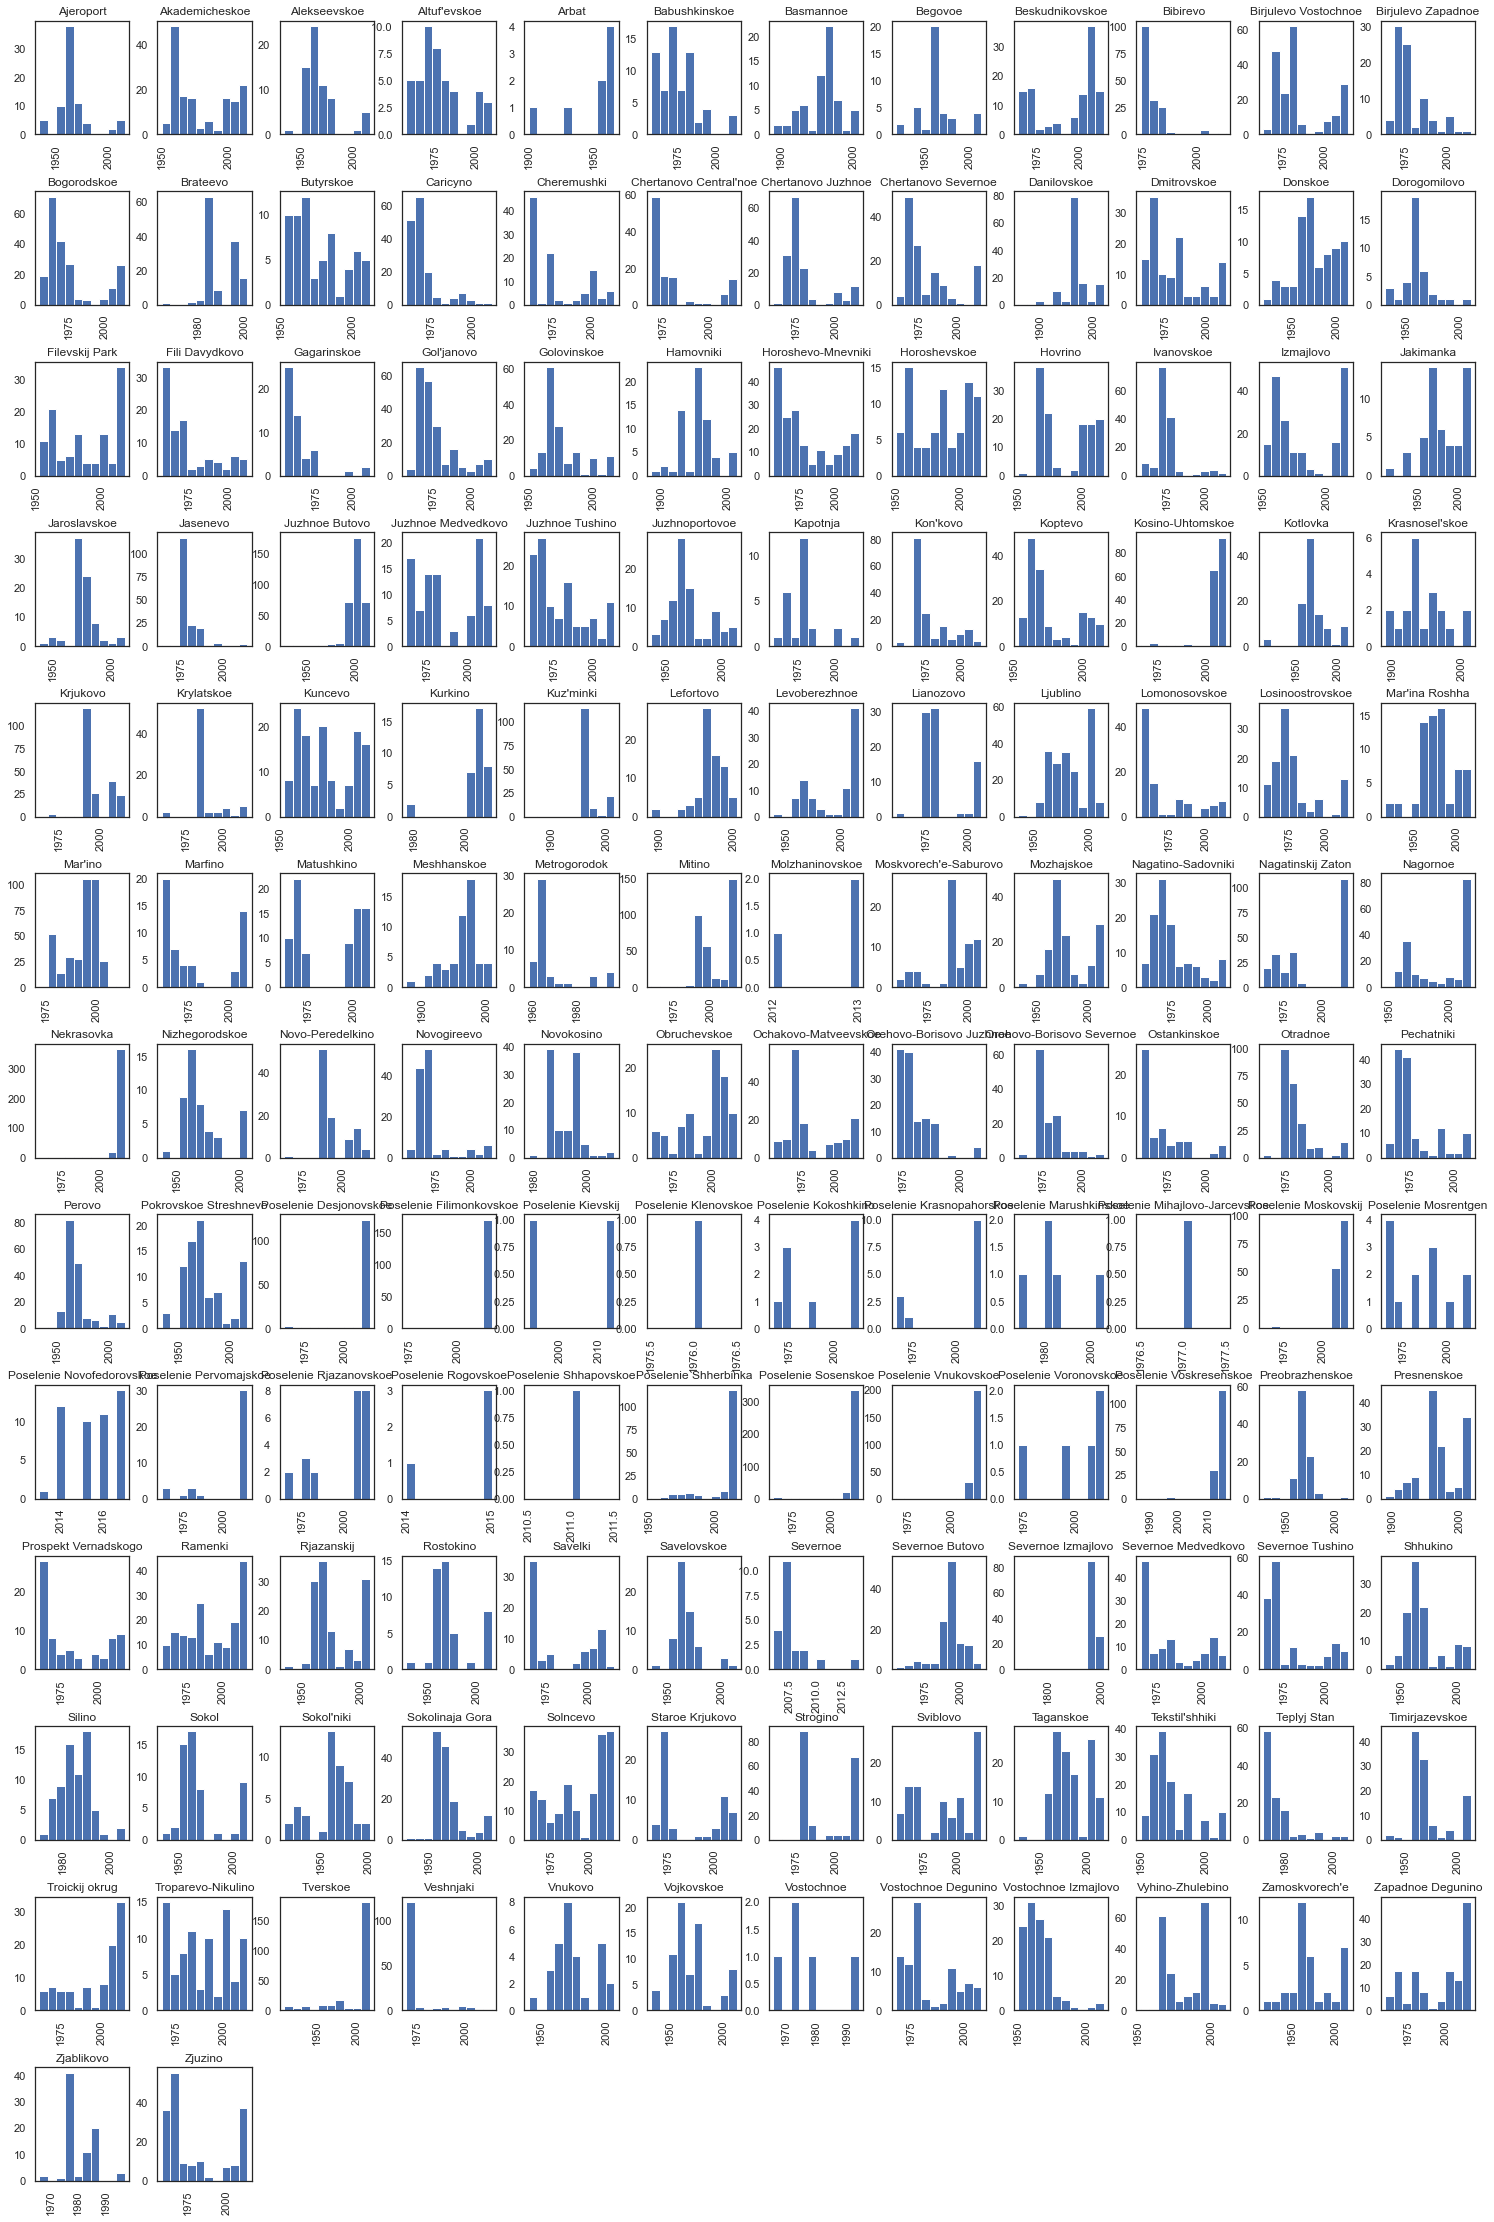

In [136]:
build_df_final['build_year'].astype(int).hist(by=build_df_final['sub_area'], figsize=(25,40));

### Apply build_year median-stratified imputation:
Treat future or ancient years as NaN so they will be imputed with the other NaNs

In [137]:
# df2 contains all original data and imputed hospital beds
df2.loc[(df['build_year'] < 1500),'build_year'] = np.nan
df2.loc[(df2['build_year'] > 2020),'build_year'] = np.nan

Imputing each sub_area's missing build_year values by the median years. We selected the mean because of housing planning under a command-type economy where market demands don't exist to smooth construction over a duration of time. Instead, with command economies, housing construction is more likely to occurr in spurts, with no growth for many years. To prevent mitigating outliers in that scenario, we selected to impute build_year with the mean of each sub_area.

In [139]:
df2['build_year'] = df2['build_year'].fillna(df2.groupby('sub_area')['build_year'].transform('mean'))

Imputations appear well placed and follow the original distributions:

Summary statistics for all non-Poselenie Neighborhoods:

In [141]:
print('After stratify-imputing build_year values by sub_area:\n')
print('Non-Poselenie Mean build year: {}\nNon-Poselenie Median build year: {}'.format(floor(df2['build_year'].mean()), floor(df2['build_year'].median())))
print('\nNon-Poselenie Minimum build year: {}\nNon-Poselenie Maximum build year: {}'.format(floor(df2['build_year'].min()), floor(df2['build_year'].max())))

After stratify-imputing build_year values by sub_area:

Non-Poselenie Mean build year: 1990
Non-Poselenie Median build year: 1992

Non-Poselenie Minimum build year: 1691
Non-Poselenie Maximum build year: 2018


# Imputing state 
State is the condition of an apartment. We impute this column by predicting state based on age, sub_area, and priori values of states for the region.

In [142]:
df3 = pd.concat([df2, df['state']], axis=1)

In [143]:
df3neigh = df3.copy()
df3lr = df3.copy() # categorical encodings for logistic regression

In [144]:
df3lr['sub_area'] = df3lr['sub_area'].astype('category').cat.codes

In [145]:
sub_area_onehots = pd.get_dummies(df3neigh['sub_area'].astype('category'))

In [146]:
df3neigh = pd.concat([df3neigh.drop('sub_area',axis=1), sub_area_onehots], axis=1) # drop sub_area because it's one-hot encoded

In [147]:
df3neigh.head()

price_doc  catering_km  zd_vokzaly_avto_km  railroad_km  ID_big_road2  \
0    5850000     0.516838           14.231961     1.305159             5   
1    6000000     0.230287            9.242586     0.694536             4   
2    5700000     0.190462            9.540544     0.700691             4   
3   13100000     0.465820           17.478380     1.999265            17   
4   16331452     0.026102            1.595898     0.084113            10   

   big_road2_km  ID_big_road1  big_road1_km  kremlin_km  bulvar_ring_km  ...  \
0      3.830951             1      1.422391   15.156211       13.675657  ...   
1      3.103996             2      2.887377    8.698054        8.132640  ...   
2      2.927487             3      0.647250    9.067885        8.054252  ...   
3      2.780449             1      2.677824   19.487005       18.309433  ...   
4      3.133531             4      1.721834    2.578671        0.787593  ...   

   Vnukovo  Vojkovskoe  Vostochnoe  Vostochnoe Degunino  Vostochnoe Izmajlovo  \
0        0           0           0                    0                     0   
1        0           0           0                    0                     0   
2        0           0           0                    0                     0   
3        0           0           0                    0                     0   
4        0           0           0                    0                     0   

   Vyhino-Zhulebino  Zamoskvorech'e  Zapadnoe Degunino  Zjablikovo  Zjuzino  
0                 0               0                  0           0        0  
1                 0               0                  0           0        0  
2                 0               0                  0           0        0  
3                 0               0                  0           0        0  
4                 0               0                  0           0        0  

[5 rows x 405 columns]

In [148]:
df3lr.head()

price_doc  catering_km  zd_vokzaly_avto_km  railroad_km  ID_big_road2  \
0    5850000     0.516838           14.231961     1.305159             5   
1    6000000     0.230287            9.242586     0.694536             4   
2    5700000     0.190462            9.540544     0.700691             4   
3   13100000     0.465820           17.478380     1.999265            17   
4   16331452     0.026102            1.595898     0.084113            10   

   big_road2_km  ID_big_road1  big_road1_km  kremlin_km  bulvar_ring_km  ...  \
0      3.830951             1      1.422391   15.156211       13.675657  ...   
1      3.103996             2      2.887377    8.698054        8.132640  ...   
2      2.927487             3      0.647250    9.067885        8.054252  ...   
3      2.780449             1      2.677824   19.487005       18.309433  ...   
4      3.133531             4      1.721834    2.578671        0.787593  ...   

   railroad_1line_yes  ecology_excellent  ecology_good  ecology_no data  \
0                   0                  0             1                0   
1                   0                  1             0                0   
2                   0                  0             0                0   
3                   0                  0             1                0   
4                   1                  1             0                0   

   ecology_poor  ecology_satisfactory  hospital_beds_raion   build_year  \
0             0                     0                240.0  1978.393939   
1             0                     0                229.0  1995.212963   
2             1                     0               1183.0  1973.647482   
3             0                     0                  0.0  2003.945946   
4             0                     0                562.0  1957.222222   

   sub_area  state  
0         9    NaN  
1        70    NaN  
2       129    NaN  
3        65    NaN  
4         6    NaN  

[5 rows x 260 columns]

In [149]:
corrcats = df3lr.corr()
corrhots = df3neigh.corr()

In [150]:
corrcats = pd.DataFrame(corrcats['state'])
corrcats['state'] = abs(corrcats['state'])

corrhots = pd.DataFrame(corrhots['state'])
corrhots['state'] = abs(corrhots['state'])

Below are the top 10 features correlating to state. We selected from this list the two features with an absolute value of correlation greater than 0.5 in addition to build_year, which was close to 0.5, but we felt is important to consider by virtue of it representing the age of a building.

In [151]:
print(corrcats.sort_values(by='state', ascending=False).head(11))
print(corrhots.sort_values(by='state', ascending=False).head(11))

                               state
state                       1.000000
product_type_Investment     0.707931
product_type_OwnerOccupier  0.707931
build_year                  0.433432
ekder_female                0.379020
ekder_all                   0.376151
raion_popul                 0.374417
work_all                    0.371903
work_male                   0.371803
work_female                 0.369736
ecology_no data             0.367248
                               state
state                       1.000000
product_type_Investment     0.707931
product_type_OwnerOccupier  0.707931
build_year                  0.433432
ekder_female                0.379020
ekder_all                   0.376151
raion_popul                 0.374417
work_all                    0.371903
work_male                   0.371803
work_female                 0.369736
ecology_no data             0.367248


### Logistic Regression

In [152]:
### The logistic regression model uses categorically-encoded data (also tested with one-hots, but naturally one-hots perform less)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

df3lr = df3lr[~df3lr['state'].isna()]
model_X = pd.DataFrame(df3lr, columns = ['product_type_Investment','product_type_OwnerOccupier','build_year'], dtype='int64')
model_y = pd.DataFrame(df3lr, columns = ['state'], dtype='int64')

X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, shuffle=True)
y_train_ravel = y_train.values.ravel()

lr.fit(X_train, y_train_ravel)

lr.predict(X_test)

print('Logistic accuracy: {}'.format(lr.score(X_test, y_test, sample_weight=None)))

Logistic accuracy: 0.5986281929990539


### K-Nearest Neighbors

In [153]:
from sklearn.neighbors import KNeighborsClassifier

df3neigh_train = df3neigh[~df3neigh['state'].isna()]
model_X = pd.DataFrame(df3neigh_train, columns = ['product_type_Investment','product_type_OwnerOccupier','build_year'], dtype='int32')
model_y = pd.DataFrame(df3neigh_train, columns = ['state'], dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, shuffle=True)
y_train_ravel = y_train.values.ravel()

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train_ravel)

neigh.predict(X_train)

print('K-NN accuracy: {}'.format(neigh.score(X_test, y_test, sample_weight=None)))

K-NN accuracy: 0.6149479659413434


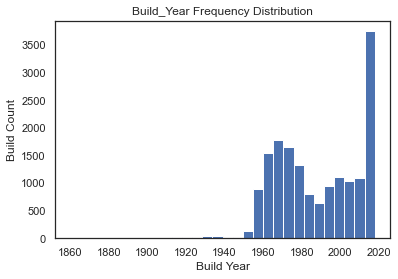

In [154]:
import matplotlib.pyplot as plt

plt.hist(df3lr['build_year'], bins=30)
plt.title('Build_Year Frequency Distribution')
plt.xlabel('Build Year')
plt.ylabel('Build Count');

In [155]:
from sklearn.neighbors import KNeighborsClassifier

df3neigh_train2 = df3neigh[~df3neigh['state'].isna()]

model_X = pd.DataFrame(df3neigh_train2, columns = ['product_type_Investment','product_type_OwnerOccupier','build_year'], dtype='int64')
model_y = pd.DataFrame(df3neigh_train2, columns = ['state'], dtype='int32')
scaler = preprocessing.StandardScaler().fit(model_X)
model_Xt = scaler.transform(model_X)

X_train2, X_test2, y_train2, y_test2 = train_test_split(model_Xt, model_y, shuffle=True)
y_train_ravel2 = y_train2.values.ravel()

neigh2 = KNeighborsClassifier(n_neighbors=3)
neigh2.fit(X_train2, y_train_ravel2)

neigh2.predict(X_train2)

print('K-NN accuracy: {}'.format(neigh2.score(X_test2, y_test2, sample_weight=None)))

K-NN accuracy: 0.609035004730369


### Predict the missing 'state' data

In [156]:
# Null State dataset
df3_null = df3neigh.loc[df3neigh['state'].isna(), :]
# Input features of the Null State dataset
df3_input = df3_null.loc[:, ['product_type_Investment','product_type_OwnerOccupier','build_year']].astype('int64')
# The No-Null dataset has no NULL values for state. Null dataset will be appended to this after imputing state
df3_nonull = df3neigh.loc[~df3neigh['state'].isna(),:]

In [157]:
# Predict 'state'
missing_state_vals = neigh.predict(df3_input)

In [158]:
np.unique(np.array(missing_state_vals))

array([1, 2, 3])

In [ ]:
df3_null['state'] = missing_state_vals

## Final imputation of build_year

In [160]:
df3_final = df3_null.append(df3_nonull)

In [161]:
df3_final['state'].unique()

array([ 2.,  3.,  1.,  4., 33.])

# Max floor

In [162]:
df4 = pd.concat([df['max_floor'],df3_final], axis=1).copy()

In [163]:
df4.shape

(30471, 406)

In [164]:
df.shape

(30471, 292)

In [165]:
df4_null = df4.loc[df4['max_floor'].isna(),:]
df4_nonull = df4.loc[~df4['max_floor'].isna(),:]

In [261]:
corr = df4_nonull.corr()

In [262]:
corrfloor = pd.DataFrame(corr['max_floor'])
corrfloor['max_floor'] = abs(corrfloor['max_floor'])

print(corrfloor.sort_values(by='max_floor', ascending=False).head(26))

                                   max_floor
max_floor                           1.000000
build_year                          0.398076
Poselenie Vnukovskoe                0.158810
additional_education_km             0.137833
shopping_centers_km                 0.133854
public_transport_station_km         0.131285
public_transport_station_min_walk   0.131285
Poselenie Moskovskij                0.128039
Nekrasovka                          0.127006
preschool_km                        0.120162
ecology_poor                        0.120057
full_sq                             0.119225
school_km                           0.118825
incineration_raion_yes              0.114295
incineration_raion_no               0.114295
ID_railroad_station_avto            0.113587
market_count_5000                   0.113341
hospital_beds_raion                 0.110610
swim_pool_km                        0.107989
ts_km                               0.107603
ecology_good                        0.103864
metro_km_a

In [263]:
top_24 = corrfloor.sort_values(by='max_floor', ascending=False).head(24)

### Building a model using the top 23 features most correlated with max_floor non-null values. This accounts for Pearson's Correlation Coefficient values greater than 0.10000

In [264]:
gt_1 = list(top_24[1:].index)

# Check for NaNs
df4_nonull.loc[:,gt_1].isna().sum()

build_year                           0
Poselenie Vnukovskoe                 0
additional_education_km              0
shopping_centers_km                  0
public_transport_station_km          0
public_transport_station_min_walk    0
Poselenie Moskovskij                 0
Nekrasovka                           0
preschool_km                         0
ecology_poor                         0
full_sq                              0
school_km                            0
incineration_raion_yes               0
incineration_raion_no                0
ID_railroad_station_avto             0
market_count_5000                    0
hospital_beds_raion                  0
swim_pool_km                         0
ts_km                                0
ecology_good                         0
metro_km_avto                        0
mkad_km                              0
metro_min_avto                       0
dtype: int64

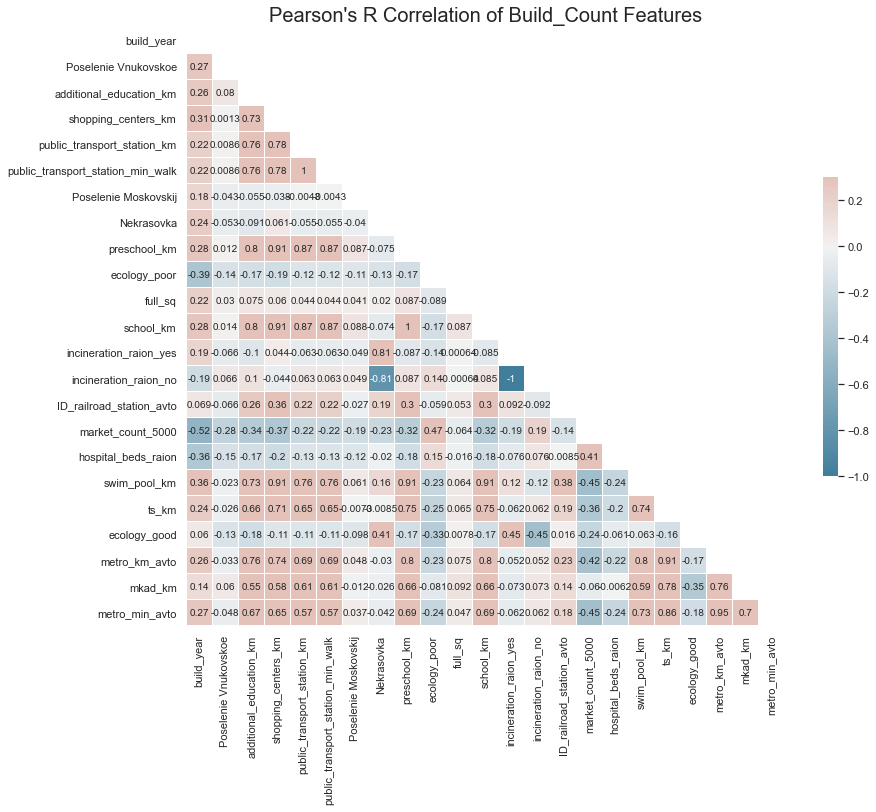

In [265]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.loc[gt_1,gt_1], dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))
plt.title("Pearson's R Correlation of Build_Count Features", fontsize = 20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.loc[gt_1,gt_1], mask=mask, 
                            cmap=cmap,
                            vmax=.3, 
                            center=0, 
                            square=True, 
                            linewidths=.1, 
                            annot= True,
                            cbar_kws={"shrink": .5});

In [170]:
model_X = pd.DataFrame(df4_nonull, columns = gt_1, dtype='int64')
model_y = pd.DataFrame(df4_nonull, columns = ['max_floor'], dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, test_size=0.33, random_state=42)

#### K-NN model for max_floor predicted on internal cross-validation with an accuracy of 49.57%. Because there are 48 floors (classes), this is a reasonable imputation method.

In [171]:
y_train_ravel = y_train.values.ravel()

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train.values.ravel())

neigh.predict(X_train)

print('K-NN accuracy: {}'.format(neigh.score(X_test, y_test.values.ravel(), sample_weight=None)))

K-NN accuracy: 0.4883282586631869


In [172]:
df4_input = pd.DataFrame(df4_null, columns = gt_1, dtype='int64')
# Predict 'state'
missing_max_floor_vals = neigh.predict(df4_input)

In [ ]:
df4_null['max_floor'] = missing_max_floor_vals.copy()

## Impute max_floor

In [174]:
df4_final = df4_null.append(df4_nonull)

## Material

In [175]:
df4_final.shape

(30471, 406)

In [176]:
df.shape[0]

30471

In [177]:
df5 = pd.concat([df['material'], df4_final], axis=1).copy()

In [178]:
df5_null = df5.loc[df5['material'].isna(),:]
df5_nonull = df5.loc[~df5['material'].isna(),:]

In [256]:
corr = df5_nonull.corr()

In [257]:
corrmat = pd.DataFrame(corr['material'])
corrmat['material'] = abs(corrmat['material'])

print(corrmat.sort_values(by='material', ascending=False).head(14))

                                   material
material                           1.000000
incineration_raion_no              0.110915
incineration_raion_yes             0.110915
ecology_good                       0.103981
Poselenie Filimonkovskoe           0.101758
sport_count_5000                   0.098482
ID_big_road2                       0.098386
Nekrasovka                         0.091680
office_sqm_5000                    0.091274
ID_railroad_terminal               0.089606
ecology_poor                       0.084120
preschool_education_centers_raion  0.078562
Nagatinskij Zaton                  0.077334
market_count_5000                  0.076378


### There are not a lot of strong correlators for material so we use everything with a coefficient correlation greater than 0.075

In [258]:
top_14 = corrmat.sort_values(by='material', ascending=False).head(14)

In [259]:
gt_75 = list(top_14[1:].index)

# Check for NaNs
df5_nonull.loc[:,gt_75].isna().sum()

incineration_raion_no                0
incineration_raion_yes               0
ecology_good                         0
Poselenie Filimonkovskoe             0
sport_count_5000                     0
ID_big_road2                         0
Nekrasovka                           0
office_sqm_5000                      0
ID_railroad_terminal                 0
ecology_poor                         0
preschool_education_centers_raion    0
Nagatinskij Zaton                    0
market_count_5000                    0
dtype: int64

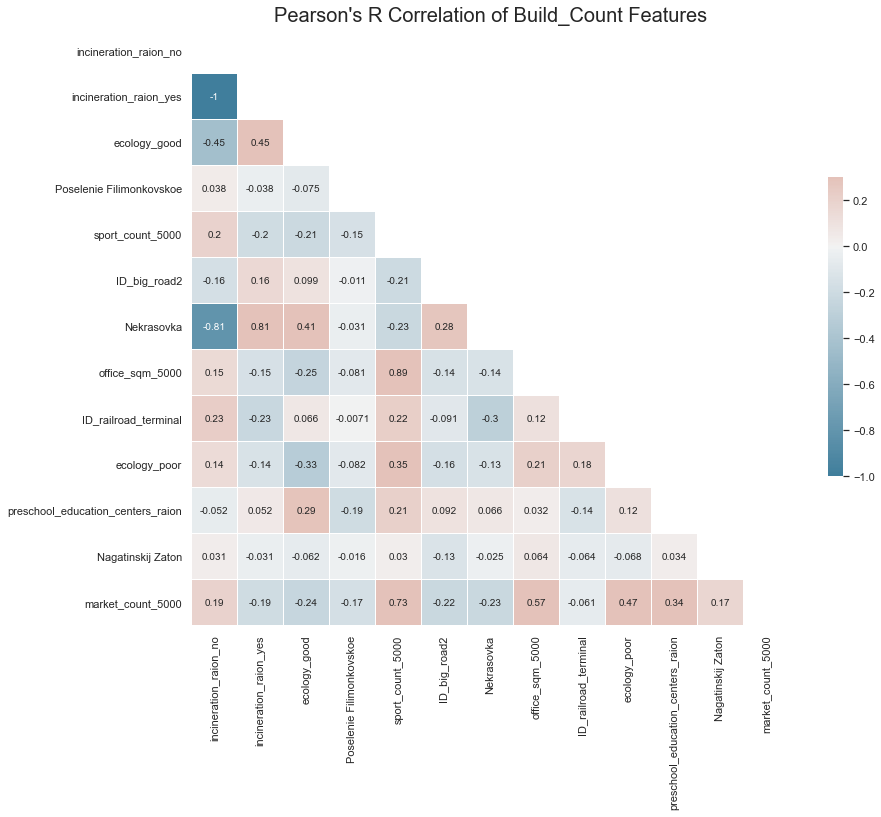

In [260]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.loc[gt_75,gt_75], dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))
plt.title("Pearson's R Correlation of Build_Count Features", fontsize = 20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.loc[gt_75,gt_75], mask=mask, 
                            cmap=cmap,
                            vmax=.3, 
                            center=0, 
                            square=True, 
                            linewidths=.1, 
                            annot= True,
                            cbar_kws={"shrink": .5});

In [183]:
model_X = pd.DataFrame(df5_nonull, columns = gt_75, dtype='int64')
model_y = pd.DataFrame(df5_nonull, columns = ['material'], dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, test_size=0.33, random_state=42)

## K-Nearest Neighbors

Based on the high cardinality in the floor counts we used K-NN to impute the missing material values. There are three one-hot encoded neighborhoods (sub_area) we used for this - Poselenie Filimonkovskoe, Nekrasovka, and Nagatinskij Zaton - which seem to have some correlation beyond complete randomness. We used additional features such as railroad terminal proximity, ecology, and inceneration raion to predict missing material values. This produced a reasonable accuracy.

In [184]:
y_train_ravel = y_train.values.ravel()

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train.values.ravel())

neigh.predict(X_train)

print('K-NN accuracy: {}'.format(neigh.score(X_test, y_test.values.ravel(), sample_weight=None)))

K-NN accuracy: 0.6807307525010874


In [185]:
df5_input = pd.DataFrame(df5_null, columns = gt_75, dtype='int64')
# Predict 'state'
missing_material_vals = neigh.predict(df5_input)

In [ ]:
df5_null['material'] = missing_material_vals

## Impute max_floor

In [187]:
df5_final = df5_null.append(df5_nonull)

## Num_Room

In [188]:
df5_final.shape

(30471, 407)

In [189]:
df.shape[0]

30471

In [250]:
df6 = pd.concat([df['num_room'], df5_final], axis=1).copy()
df6_null = df6.loc[df6['num_room'].isna(),:]
df6_nonull = df6.loc[~df6['num_room'].isna(),:]

corr = df6_nonull.corr()

In [251]:
corrnum = pd.DataFrame(corr['num_room'])
corrnum['num_room'] = abs(corrnum['num_room'])

print(corrnum.sort_values(by='num_room', ascending=False).head(20))

                                num_room
num_room                        1.000000
full_sq                         0.695444
price_doc                       0.476337
trc_count_5000                  0.095754
sport_count_3000                0.094744
sport_count_2000                0.092989
product_type_Investment         0.092958
product_type_OwnerOccupier      0.092958
sport_objects_raion             0.092301
state                           0.091330
sport_count_1500                0.090289
sport_count_5000                0.089908
trc_count_3000                  0.089479
ekder_male                      0.087803
build_year                      0.087792
trc_sqm_3000                    0.085805
trc_sqm_5000                    0.085796
ekder_all                       0.083390
school_education_centers_raion  0.082814
ekder_female                    0.081012


In [252]:
top_80 = corrnum.sort_values(by='num_room', ascending=False).head(20).drop('price_doc')

In [253]:
gt_80 = list(top_80[1:].index)

# Check for NaNs
df6_nonull.loc[:,gt_80].isna().sum()

full_sq                           0
trc_count_5000                    0
sport_count_3000                  0
sport_count_2000                  0
product_type_Investment           0
product_type_OwnerOccupier        0
sport_objects_raion               0
state                             0
sport_count_1500                  0
sport_count_5000                  0
trc_count_3000                    0
ekder_male                        0
build_year                        0
trc_sqm_3000                      0
trc_sqm_5000                      0
ekder_all                         0
school_education_centers_raion    0
ekder_female                      0
dtype: int64

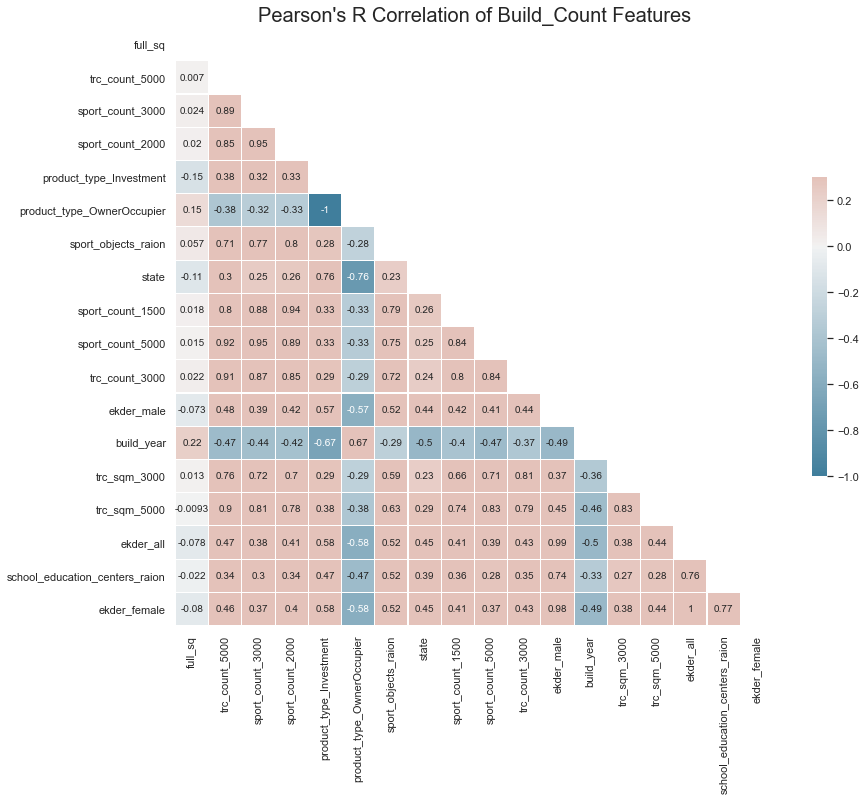

In [255]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.loc[gt_80,gt_80], dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))
plt.title("Pearson's R Correlation of Build_Count Features", fontsize = 20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.loc[gt_80,gt_80], mask=mask, 
                            cmap=cmap,
                            vmax=.3, 
                            center=0, 
                            square=True, 
                            linewidths=.1, 
                            annot= True,
                            cbar_kws={"shrink": .5});

In [194]:
model_X = pd.DataFrame(df6_nonull, columns = gt_80, dtype='int64')
model_y = pd.DataFrame(df6_nonull, columns = ['num_room'], dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, test_size=0.33, random_state=42)

In [195]:
y_train_ravel = y_train.values.ravel()

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train.values.ravel())

neigh.predict(X_train)

print('K-NN accuracy: {}'.format(neigh.score(X_test, y_test.values.ravel(), sample_weight=None)))

K-NN accuracy: 0.6033057851239669


In [196]:
df6_input = pd.DataFrame(df6_null, columns = gt_80, dtype='int64')
# Predict 'state'
missing_num_room_vals = neigh.predict(df6_input)

In [ ]:
df6_null['num_room'] = missing_num_room_vals

In [198]:
df6_null['num_room'].isna().sum()

0

## Impute Num_Room

In [199]:
df6_final = df6_null.append(df6_nonull)

## Floor

In [201]:
df6_final.shape

(30471, 408)

In [202]:
df.shape[0]

30471

In [246]:
df7 = pd.concat([df['floor'], df6_final], axis=1).copy()
df7_null = df7.loc[df7['floor'].isna(),:]
df7_nonull = df7.loc[~df7['floor'].isna(),:]

corr = df7_nonull.corr()

In [247]:
corrfloor2 = pd.DataFrame(corr['floor'])
corrfloor2['floor'] = abs(corrfloor2['floor'])

print(corrfloor2.sort_values(by='floor', ascending=False).head(16))

                                      floor
floor                              1.000000
max_floor                          0.358529
build_year                         0.302923
product_type_Investment            0.206810
product_type_OwnerOccupier         0.206810
state                              0.150811
Nekrasovka                         0.124175
market_count_5000                  0.123843
ecology_poor                       0.117836
price_doc                          0.117447
Mitino                             0.110668
incineration_raion_no              0.105664
incineration_raion_yes             0.105664
sport_count_5000                   0.102101
public_transport_station_km        0.101283
public_transport_station_min_walk  0.101283


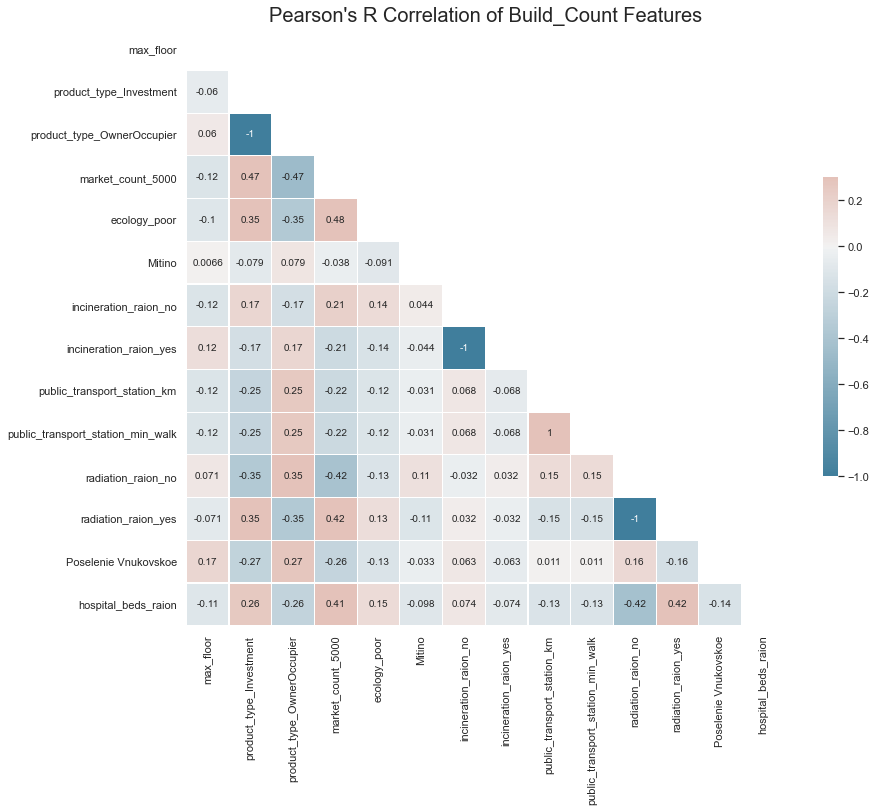

In [249]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.loc[gt_1,gt_1], dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))
plt.title("Pearson's R Correlation of Build_Count Features", fontsize = 20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.loc[gt_1,gt_1], mask=mask, 
                            cmap=cmap,
                            vmax=.3, 
                            center=0, 
                            square=True, 
                            linewidths=.1, 
                            annot= True,
                            cbar_kws={"shrink": .5});

#### We removed features that had strong correlation with other input features.
We gave preference to features that had not previously been imputed. While this may have resulted in less explanation of overall variation for the target (floor), we felt this conservative approach to be more appropriate and risk averse. We considered strong correlation to be greater than 0.5.

Where possible, we minimized re-using features used in imputing other features when there was reasonable correlation. We did this in an effort to preserve original, "intended" variation ("intended" in reference to the assumption missing values should not have been missing). One example of this was selecting sport_count_5000, which had been used to impute num_room. sport_count_5000 shares a Pearson's correlation coefficient greater than 0.733 with market_count_5000, but was used to impute num_room. Therefore, we used market_count_5000 to impute floor.

In [206]:
top_1 = corrfloor2.sort_values(by='floor', ascending=False).head(20).drop(['price_doc','build_year','state','sport_count_5000','Nekrasovka'])

In [207]:
gt_1 = list(top_1[1:].index)

# Check for NaNs
df7_nonull.loc[:,gt_1].isna().sum()

max_floor                            0
product_type_Investment              0
product_type_OwnerOccupier           0
market_count_5000                    0
ecology_poor                         0
Mitino                               0
incineration_raion_no                0
incineration_raion_yes               0
public_transport_station_km          0
public_transport_station_min_walk    0
radiation_raion_no                   0
radiation_raion_yes                  0
Poselenie Vnukovskoe                 0
hospital_beds_raion                  0
dtype: int64

In [208]:
model_X = pd.DataFrame(df7_nonull, columns = gt_1, dtype='int64')
model_y = pd.DataFrame(df7_nonull, columns = ['floor'], dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, test_size=0.33, random_state=42)

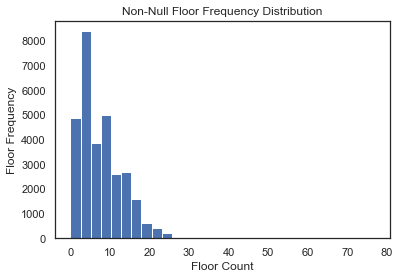

In [209]:
plt.hist(df7_nonull['floor'], bins=30);
plt.title('Non-Null Floor Frequency Distribution')
plt.xlabel('Floor Count')
plt.ylabel('Floor Frequency');

In [210]:
y_train_ravel = y_train.values.ravel()

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train.values.ravel())

neigh.predict(X_train)

print('K-NN accuracy: {}'.format(neigh.score(X_test, y_test.values.ravel(), sample_weight=None)))

K-NN accuracy: 0.09909009099090091


In [211]:
df7_input = pd.DataFrame(df7_null, columns = gt_1, dtype='int64')

In [212]:
# Predict 'state'
missing_floor2_vals = neigh.predict(df7_input)

### The distribution of the K-NN model appears to provide a reasonable approximation to the Floor feature's non-missing distribution, despite having a poor accuracy (less than 10%). Therefore, we selected this approach over an alternative imputation method.

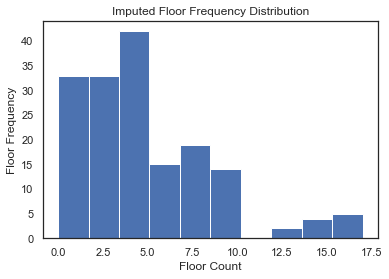

In [213]:
plt.hist(missing_floor2_vals)
plt.title('Imputed Floor Frequency Distribution')
plt.xlabel('Floor Count')
plt.ylabel('Floor Frequency');

## Impute Floor

In [ ]:
df7_null['floor'] = missing_floor2_vals

In [215]:
df7_null['floor'].isna().sum()

0

In [216]:
df7_final = df7_null.append(df7_nonull)

In [ ]:
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
# Paul's junkyard of bad ideas. Will delete after confirming nobody is using any of this

In [ ]:
df_no_null_hosp = pd.concat([df_no_null, df['hospital_beds_raion']], axis=1)

In [ ]:
df_no_null_hosp.head()

In [ ]:
df.loc[df['build_year'].notna(),'build_year'] = 0

In [ ]:
df_bldyr = pd.concat([df['sub_area'],df['build_year']], axis=1)

In [ ]:
df_bldyr.loc[neighborhoods[neighborhoods['build_year'].notnull(),]]

In [ ]:
neighborhoods.groupby(neighborhoods[neighborhoods['build_year'].notnull(),])

In [ ]:
t = neighborhoods.groupby(neighborhoods['sub_area']).median()

In [ ]:
df_bldyr.loc[df_bldyr['build_year'].notnull(),:]

In [ ]:
neighborhoods = pd.concat([df_no_null_hosp['sub_area'],df_no_null_hosp['build_year']], axis=1)
t = neighborhoods.groupby(neighborhoods['sub_area']).median()

#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
t.sort_values(by='sub_area', ascending=True).head() # Missing values appear as 0

In [ ]:
neighborhoods.groupby(neighborhoods['sub_area']).median()

In [ ]:
df.loc[df['build_year'].isna(),'build_year'] = neighborhoods.groupby(neighborhoods['sub_area']).median()

In [ ]:
df.loc[df['build_year'].isna(),'build_year']

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(df_no_null_hosp)

In [ ]:
y = df_no_null['price_doc']
X = df_no_null.drop(['price_doc'], axis=1)
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
y_train_buildyr = df.loc[df['build_year'].notna(),'build_year']

In [ ]:
list(na_list.index)

In [ ]:
nullList = df.isnull().sum()
na_list=nullList[nullList>0].sort_values(ascending=False)

In [ ]:
list(na_list.index)

In [ ]:
df[list(na_list.index)].head()

In [ ]:
X_train_buildyr = df.drop([na_list.index],axis=1)

In [ ]:
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
###############################################################################################################
# No more stuff from Paul

## Build_Count Features

The dataset also contains a large number of features that represent counts of homes with specific building materials. These features are counts of homes with materials, we will assume that missing values means that those materials are absent and we will impute them with 0 values. A more detailed justification of this decision is provided below.

Each of these features contain 4,991 missing values. The sub_area feature was appended to the build_count dataframe, revealing that sub-areas with the Polesenskie prefix contain all of the missing values across all of the build_count features. Of the subset of features having at least 1 missing value, a majority of the missing values were found to be in the `build_count_foam` and `build_count_panel`. Additionally, a correlation matrix revealed that `raion_build_count_with_builddate_info` and `raion_build_count_with_material_info` are almost perfectly correlated, so we chose to remove `raion_build_count_with_builddate_info` from the dataset.

In [217]:
names = df.columns
# filtering column names for the build_count features
string = ['build_count']
build_cols = [i for i in names if any(sub in i for sub in string)]
# sub_area is appended to the list to find spatial correlations
build_cols.append('sub_area')

In [218]:
# creating a subset of the build_count features
build_count_df = df[build_cols]
build_count_df.describe()

raion_build_count_with_material_info  build_count_block  \
count                          25480.000000       25480.000000   
mean                             328.660636          50.297449   
std                              277.904011          46.937628   
min                                1.000000           0.000000   
25%                              180.000000          13.000000   
50%                              273.000000          42.000000   
75%                              400.000000          72.000000   
max                             1681.000000         223.000000   

       build_count_wood  build_count_frame  build_count_brick  \
count      25480.000000       25480.000000       25480.000000   
mean          40.848430           4.954984         108.048705   
std          126.740377          14.926934         129.120421   
min            0.000000           0.000000           0.000000   
25%            0.000000           0.000000          10.000000   
50%            0.000000           0.000000          67.000000   
75%            7.000000           1.000000         156.000000   
max          793.000000          97.000000         664.000000   

       build_count_monolith  build_count_panel  build_count_foam  \
count          25480.000000       25480.000000      25480.000000   
mean              12.043642         107.236892          0.165581   
std               19.278997          88.259709          1.133023   
min                0.000000           0.000000          0.000000   
25%                2.000000          35.000000          0.000000   
50%                6.000000          92.000000          0.000000   
75%               13.000000         157.000000          0.000000   
max              127.000000         431.000000         11.000000   

       build_count_slag  build_count_mix  \
count      25480.000000     25480.000000   
mean           4.491797         0.573155   
std           13.227435         1.530126   
min            0.000000         0.000000   
25%            0.000000         0.000000   
50%            0.000000         0.000000   
75%            2.000000         0.000000   
max           84.000000         9.000000   

       raion_build_count_with_builddate_info  build_count_before_1920  \
count                           25480.000000             25480.000000   
mean                              328.328493                18.899294   
std                               277.917031                60.983271   
min                                 1.000000                 0.000000   
25%                               178.000000                 0.000000   
50%                               271.000000                 0.000000   
75%                               400.000000                 3.000000   
max                              1680.000000               371.000000   

       build_count_1921-1945  build_count_1946-1970  build_count_1971-1995  \
count           25480.000000           25480.000000           25480.000000   
mean               26.721586             141.426413              80.130377   
std                62.512263             125.427822              57.873880   
min                 0.000000               0.000000               0.000000   
25%                 0.000000              14.000000              37.000000   
50%                 2.000000             135.000000              71.000000   
75%                20.000000             216.000000             111.000000   
max               382.000000             845.000000             246.000000   

       build_count_after_1995  
count            25480.000000  
mean                61.150824  
std                114.222229  
min                  0.000000  
25%                 14.000000  
50%                 24.000000  
75%                 57.000000  
max                799.000000

In [219]:
build_count_df.isnull().sum()


raion_build_count_with_material_info     4991
build_count_block                        4991
build_count_wood                         4991
build_count_frame                        4991
build_count_brick                        4991
build_count_monolith                     4991
build_count_panel                        4991
build_count_foam                         4991
build_count_slag                         4991
build_count_mix                          4991
raion_build_count_with_builddate_info    4991
build_count_before_1920                  4991
build_count_1921-1945                    4991
build_count_1946-1970                    4991
build_count_1971-1995                    4991
build_count_after_1995                   4991
sub_area                                    0
dtype: int64

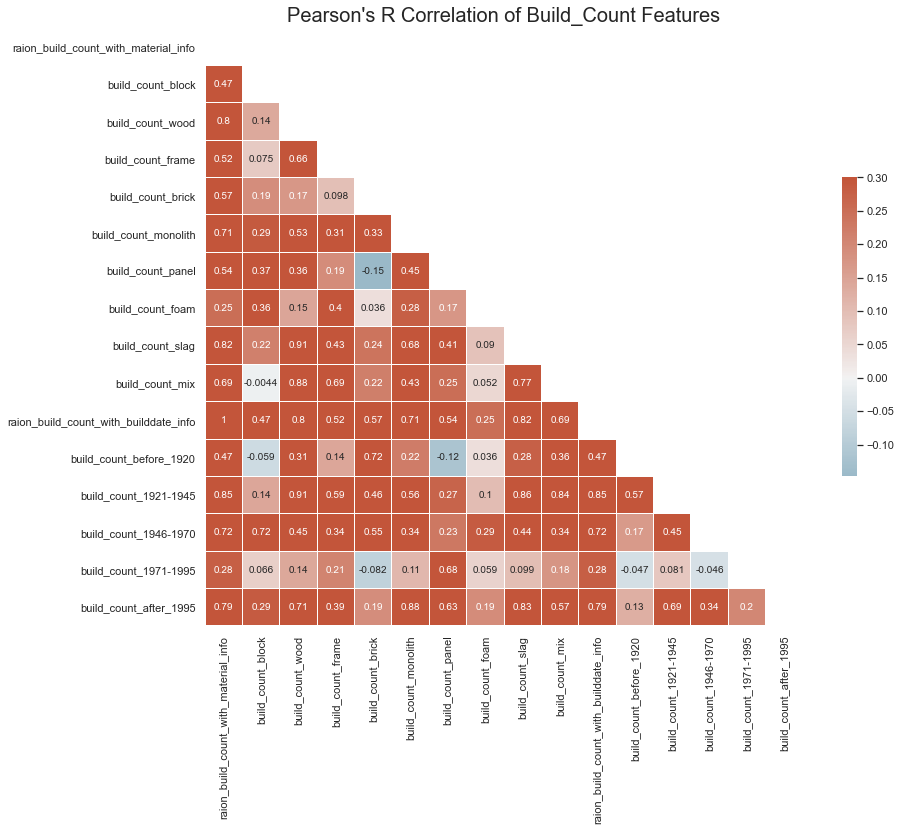

In [220]:
materials_corr = build_count_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(materials_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))
plt.title("Pearson's R Correlation of Build_Count Features", fontsize = 20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(materials_corr, mask=mask, 
                            cmap=cmap,
                            vmax=.3, 
                            center=0, 
                            square=True, 
                            linewidths=.1, 
                            annot= True,
                            cbar_kws={"shrink": .5});

In [221]:
p_regions = list(np.unique(build_count_df['sub_area']))
poselenie_areas = [i for i in p_regions if any(sub in i for sub in ['Pos'])]
poselenie_areas

['Poselenie Desjonovskoe',
 'Poselenie Filimonkovskoe',
 'Poselenie Kievskij',
 'Poselenie Klenovskoe',
 'Poselenie Kokoshkino',
 'Poselenie Krasnopahorskoe',
 'Poselenie Marushkinskoe',
 'Poselenie Mihajlovo-Jarcevskoe',
 'Poselenie Moskovskij',
 'Poselenie Mosrentgen',
 'Poselenie Novofedorovskoe',
 'Poselenie Pervomajskoe',
 'Poselenie Rjazanovskoe',
 'Poselenie Rogovskoe',
 'Poselenie Shhapovskoe',
 'Poselenie Shherbinka',
 'Poselenie Sosenskoe',
 'Poselenie Vnukovskoe',
 'Poselenie Voronovskoe',
 'Poselenie Voskresenskoe']

In [222]:
poselenie_df = build_count_df[build_count_df.sub_area.isin(poselenie_areas)]

poselenie_df.describe()

raion_build_count_with_material_info  build_count_block  \
count                           1536.000000        1536.000000   
mean                               1.987630           0.096354   
std                               11.160387           0.295172   
min                                1.000000           0.000000   
25%                                1.000000           0.000000   
50%                                1.000000           0.000000   
75%                                2.000000           0.000000   
max                              180.000000           1.000000   

       build_count_wood  build_count_frame  build_count_brick  \
count       1536.000000        1536.000000        1536.000000   
mean           1.376302           0.183594           0.035156   
std            7.499164           2.932712           0.561583   
min            0.000000           0.000000           0.000000   
25%            1.000000           0.000000           0.000000   
50%            1.000000           0.000000           0.000000   
75%            1.000000           0.000000           0.000000   
max          121.000000          47.000000           9.000000   

       build_count_monolith  build_count_panel  build_count_foam  \
count           1536.000000             1536.0            1536.0   
mean               0.003906                0.0               0.0   
std                0.062398                0.0               0.0   
min                0.000000                0.0               0.0   
25%                0.000000                0.0               0.0   
50%                0.000000                0.0               0.0   
75%                0.000000                0.0               0.0   
max                1.000000                0.0               0.0   

       build_count_slag  build_count_mix  \
count       1536.000000           1536.0   
mean           0.292318              0.0   
std            0.454976              0.0   
min            0.000000              0.0   
25%            0.000000              0.0   
50%            0.000000              0.0   
75%            1.000000              0.0   
max            1.000000              0.0   

       raion_build_count_with_builddate_info  build_count_before_1920  \
count                            1536.000000              1536.000000   
mean                                1.987630                 0.003906   
std                                11.160387                 0.062398   
min                                 1.000000                 0.000000   
25%                                 1.000000                 0.000000   
50%                                 1.000000                 0.000000   
75%                                 2.000000                 0.000000   
max                               180.000000                 1.000000   

       build_count_1921-1945  build_count_1946-1970  build_count_1971-1995  \
count            1536.000000            1536.000000            1536.000000   
mean                0.003906               1.843099               0.046875   
std                 0.062398               8.854053               0.748778   
min                 0.000000               1.000000               0.000000   
25%                 0.000000               1.000000               0.000000   
50%                 0.000000               1.000000               0.000000   
75%                 0.000000               2.000000               0.000000   
max                 1.000000             143.000000              12.000000   

       build_count_after_1995  
count             1536.000000  
mean                 0.089844  
std                  1.435157  
min                  0.000000  
25%                  0.000000  
50%                  0.000000  
75%                  0.000000  
max                 23.000000

In [223]:
nulls = build_count_df[build_count_df.isnull().any(axis=1)]
nulls['sub_area'].value_counts()

Poselenie Sosenskoe               1776
Poselenie Vnukovskoe              1372
Poselenie Voskresenskoe            713
Poselenie Filimonkovskoe           496
Poselenie Desjonovskoe             362
Poselenie Novofedorovskoe          148
Poselenie Rjazanovskoe              34
Poselenie Rogovskoe                 31
Poselenie Krasnopahorskoe           27
Poselenie Mosrentgen                19
Poselenie Voronovskoe                7
Poselenie Kievskij                   2
Poselenie Shhapovskoe                2
Poselenie Mihajlovo-Jarcevskoe       1
Poselenie Klenovskoe                 1
Name: sub_area, dtype: int64

In [224]:
for i in build_cols:
    df[i].fillna(0, inplace=True)

In [225]:
no_na = df.dropna()
no_na.shape

(9185, 292)

In [226]:
no_null_corr = no_na.corr()

In [227]:
life_corr = no_null_corr['life_sq'].sort_values(ascending=False)
life_corr.head(10)

life_sq                       1.000000
full_sq                       0.845815
num_room                      0.609960
price_doc                     0.537930
cafe_count_1500_price_2500    0.201385
cafe_count_1500_na_price      0.200318
cafe_count_3000_price_2500    0.199583
cafe_count_1500               0.199286
cafe_count_1500_price_1500    0.199174
cafe_count_2000_price_2500    0.198968
Name: life_sq, dtype: float64

In [228]:
sq_ft_features = ['life_sq', 'full_sq', 'num_room', 'price_doc']
full_sq_data = df[sq_ft_features]

In [229]:
full_sq_data['price_doc'].isnull().sum()

0

In [230]:
y = full_sq_data['price_doc']
X = full_sq_data.drop('price_doc', axis = 1)
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state)

## Multiple Imputation Strategies (Multiple Linear Regression and KNN)
### Multiple Linear Regression

In [231]:
imp = IterativeImputer(max_iter= 10000, random_state = random_state)
imp.fit(X_train)

imp_train = imp.transform(X_train)
imp_test = imp.transform(X_test)

In [232]:
dfs = {'train--':imp_train, 'test--':imp_test}
for i, j in dfs.items():
    print(i, 'nan count: ', sum(np.isnan(j)), 'infinites: ', sum(np.isinf(j)), '\n')

train-- nan count:  [0 0 0] infinites:  [0 0 0] 

test-- nan count:  [0 0 0] infinites:  [0 0 0] 



### KNN Imputer

In [233]:
KNNimp = KNNImputer(n_neighbors = 3)
KNNimp.fit(X_train)

KNNimp_train = KNNimp.transform(X_train)
KNNimp_test = KNNimp.transform(X_test)

## Comparing the performance of Multiple Imputation Strategies

In [234]:
from sklearn.linear_model import ElasticNetCV
# instantiate the elastic net regularizer
EN = ElasticNetCV(l1_ratio = .5, 
                  cv = 5,
                  n_jobs = -1,
                  random_state = random_state)
# fit a model to the Iteratively Imputed training data
IIimputed_model = EN.fit(imp_train, y_train)
# fit the same model to the KNN Imputed training data
KNNimputed_model = EN.fit(KNNimp_train, y_train)
# predict the target using Iteratively Imputed test data
II_preds = IIimputed_model.predict(imp_test)
# predict the target using KNN imputed test data
KNN_preds = KNNimputed_model.predict(KNNimp_test)

II_MSE = np.mean((II_preds - y_test)**2)
KNN_MSE = np.mean((KNN_preds - y_test)**2)
print('Iterative Imputed model error: ', II_MSE,
      '\nKNN Imputed model error: ', KNN_MSE)

Iterative Imputed model error:  21255964463341.004 
KNN Imputed model error:  21248249768501.598


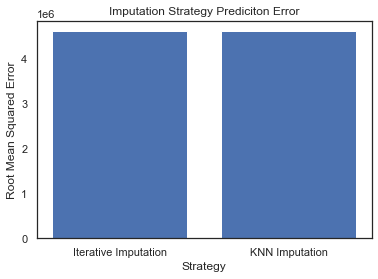

In [235]:
labels = ['Iterative Imputation', 'KNN Imputation']
errors = [np.sqrt(II_MSE), np.sqrt(KNN_MSE)]
plt.bar(range(2), errors)
plt.title('Imputation Strategy Prediction Error')
plt.xlabel('Strategy')
plt.ylabel('Root Mean Squared Error')
plt.xticks(range(2), labels)
plt.show()

In [236]:
np.sqrt(II_MSE) -np.sqrt(KNN_MSE)

836.7346615623683

In [4]:
walking = [i for i in df.columns if any(sub in i for sub in ['walk'])]
walking

['metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'ID_railroad_station_walk',
 'public_transport_station_min_walk']

In [5]:
for i in walking:
    print(i, pd.isna(df[i]).sum())

metro_min_walk 25
metro_km_walk 25
railroad_station_walk_km 25
railroad_station_walk_min 25
ID_railroad_station_walk 25
public_transport_station_min_walk 0


In [7]:
walking_df = df[walking[:5]]
walking_corr = walking_df.corr()

### Walking Distance Features

Five walking distance features each have 25 missing data points. A Pearson's R correlation matrix reveals multicollinearity between features that account for walking distance and those that account for the time it takes to walk from one point to another. We will remove the walking time measurements, `metro_min_walk` and `railroad_station_walk_min` because they are the more subjective of the two.

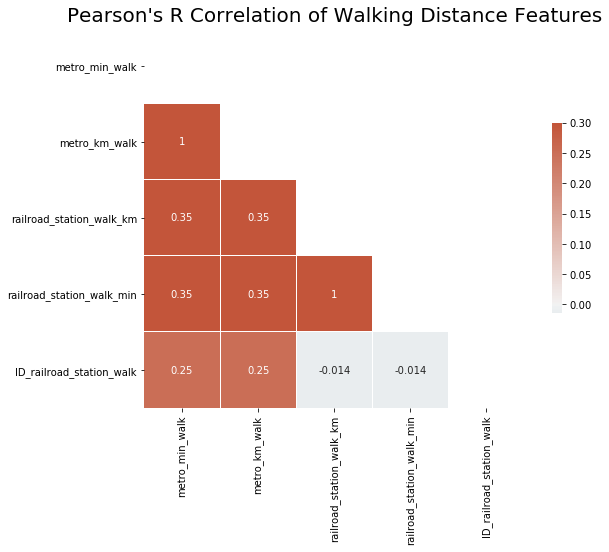

In [11]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(walking_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,7))
plt.title("Pearson's R Correlation of Walking Distance Features", fontsize = 20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(walking_corr, mask=mask, 
                            cmap=cmap,
                            vmax=.3, 
                            center=0, 
                            square=True, 
                            linewidths=.1, 
                            annot= True,
                            cbar_kws={"shrink": .5});

In [14]:
droppers = ['metro_min_walk','railroad_station_walk_min']
df = df.drop(droppers, axis = 1)

In [17]:
walking = ['metro_km_walk', 'railroad_station_walk_km', 'ID_railroad_station_walk', 'sub_area']
df_walking = df[walking]

In [30]:
pd.options.display.max_rows = 25
walking_nulls = df_walking[df_walking.isnull().any(axis=1)]
walking_nulls

metro_km_walk  railroad_station_walk_km  ID_railroad_station_walk  \
10709            NaN                       NaN                       NaN   
13259            NaN                       NaN                       NaN   
13699            NaN                       NaN                       NaN   
14796            NaN                       NaN                       NaN   
15790            NaN                       NaN                       NaN   
17358            NaN                       NaN                       NaN   
18255            NaN                       NaN                       NaN   
19344            NaN                       NaN                       NaN   
19370            NaN                       NaN                       NaN   
19477            NaN                       NaN                       NaN   
21593            NaN                       NaN                       NaN   
21717            NaN                       NaN                       NaN   
24553            NaN                       NaN                       NaN   
26944            NaN                       NaN                       NaN   
27004            NaN                       NaN                       NaN   
27199            NaN                       NaN                       NaN   
27875            NaN                       NaN                       NaN   
28213            NaN                       NaN                       NaN   
28669            NaN                       NaN                       NaN   
28933            NaN                       NaN                       NaN   
29494            NaN                       NaN                       NaN   
29763            NaN                       NaN                       NaN   
29830            NaN                       NaN                       NaN   
29946            NaN                       NaN                       NaN   
30037            NaN                       NaN                       NaN   

                   sub_area  
10709        Timirjazevskoe  
13259        Timirjazevskoe  
13699               Begovoe  
14796        Timirjazevskoe  
15790            Vojkovskoe  
17358        Timirjazevskoe  
18255               Begovoe  
19344        Timirjazevskoe  
19370        Timirjazevskoe  
19477        Timirjazevskoe  
21593            Vojkovskoe  
21717        Timirjazevskoe  
24553  Ochakovo-Matveevskoe  
26944  Poselenie Vnukovskoe  
27004        Timirjazevskoe  
27199  Ochakovo-Matveevskoe  
27875  Poselenie Vnukovskoe  
28213        Timirjazevskoe  
28669  Poselenie Vnukovskoe  
28933            Krylatskoe  
29494        Timirjazevskoe  
29763            Krylatskoe  
29830            Krylatskoe  
29946            Krylatskoe  
30037            Krylatskoe

In [32]:
walking_subs = np.unique(walking_nulls['sub_area'])
walking_subs

array(['Begovoe', 'Krylatskoe', 'Ochakovo-Matveevskoe',
       'Poselenie Vnukovskoe', 'Timirjazevskoe', 'Vojkovskoe'],
      dtype=object)

### Imputing Walking Features

The missing walking data appear to be missing at random. Since there are only 25 of these missing values, we decided to use the median values for each feature as the imputed value rather than using a predictive technique. We rounded the walking distance features with a single digit of precision and the `ID_railroad_station_walk` feauture was imputed without any digits of precision because it is simply an identifier.

In [39]:
walking_sub_df = df[df.sub_area.isin(walking_subs)]
walking_sub_df = walking_sub_df[walking]
walking_sub_df.describe()

metro_km_walk  railroad_station_walk_km  ID_railroad_station_walk
count    2050.000000               2050.000000               2050.000000
mean        2.676132                  3.173610                 47.477073
std         1.728267                  1.403900                 33.614089
min         0.115775                  0.091549                 10.000000
25%         1.722233                  2.096932                 24.000000
50%         2.200402                  3.735666                 24.000000
75%         3.220435                  4.299245                 63.000000
max         8.038429                  7.816257                118.000000

In [52]:
df[df['metro_km_walk'].isnull()] = int(round(walking_sub_df['metro_km_walk'].median(),1))
df[df['railroad_station_walk_km'].isnull()] = int(round(walking_sub_df['railroad_station_walk_km'].median(),1))
df[df['ID_railroad_station_walk'].isnull()] = int(round(walking_sub_df['ID_railroad_station_walk'].median(),0))

In [53]:
for i in walking_sub_df.columns:
    print(i, sum(pd.isna(df[i])))

metro_km_walk 0
railroad_station_walk_km 0
ID_railroad_station_walk 0
sub_area 0


### Prom Features

In [63]:
prom = [i for i in df.columns if any(sub in i for sub in ['prom'])]
prom

['prom_part_500',
 'prom_part_1000',
 'prom_part_1500',
 'prom_part_2000',
 'prom_part_3000',
 'prom_part_5000']

In [55]:
for i in prom:
    print(i, sum(pd.isna(df[i])))

prom_part_500 0
prom_part_1000 0
prom_part_1500 0
prom_part_2000 0
prom_part_3000 0
prom_part_5000 178


In [64]:
prom.append('sub_area')
prom_df = df[prom]
prom_na = prom_df[prom_df.isna()]
prom_df.describe()

prom_part_500  prom_part_1000  prom_part_1500  prom_part_2000  \
count   30471.000000    30471.000000    30471.000000    30471.000000   
mean        5.708097        8.771085       10.585864       11.212062   
std        11.535957       11.510945       10.972875        9.638425   
min         0.000000        0.000000        0.000000        0.000000   
25%         0.000000        0.000000        1.520000        3.120000   
50%         0.000000        3.990000        7.810000        8.800000   
75%         5.760000       12.620000       15.310000       16.210000   
max        98.770000       72.200000       63.000000       56.100000   

       prom_part_3000  prom_part_5000  
count    30471.000000    30293.000000  
mean        10.968362       10.341906  
std          7.939677        5.672063  
min          0.000000        0.210000  
25%          4.220000        6.050000  
50%          9.650000        8.960000  
75%         15.730000       14.000000  
max         45.100000       28.560000

In [67]:
corr = df.corr()
prom_5000_corr = corr['prom_part_5000'].sort_values(ascending =False)
prom_5000_corr.head(10)

prom_part_5000       1.000000
prom_part_3000       0.797736
market_count_5000    0.639495
prom_part_2000       0.508599
market_count_3000    0.500044
trc_count_5000       0.496383
trc_sqm_5000         0.461879
sport_count_5000     0.411527
market_count_2000    0.373343
prom_part_1500       0.365271
Name: prom_part_5000, dtype: float64

In [70]:
imp = IterativeImputer(max_iter= 10000, random_state = random_state)
KNNimp = KNNImputer(n_neighbors = 3)

prom_imputes = ['prom_part_5000','prom_part_3000','market_count_5000','prom_part_2000', 'price_doc']
prom_imputed = df[prom_imputes]

y = prom_imputed['price_doc']
X = prom_imputed.drop('price_doc', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = random_state)

In [72]:
II_imp_train = imp.fit_transform(X_train)
KNN_imp_train = KNNimp.fit_transform(X_train)

II_imp_test = imp.transform(X_test)
KNN_imp_test = KNNimp.transform(X_test)

In [74]:
from sklearn.linear_model import ElasticNetCV
# instantiate the elastic net regularizer
EN = ElasticNetCV(l1_ratio = .5, 
                  cv = 5,
                  n_jobs = -1,
                  random_state = random_state)
# fit a model to the Iteratively Imputed training data
IIimputed_model = EN.fit(II_imp_train, y_train)
# fit the same model to the KNN Imputed training data
KNNimputed_model = EN.fit(KNN_imp_train, y_train)
# predict the target using Iteratively Imputed test data
II_preds = IIimputed_model.predict(II_imp_test)
# predict the target using KNN imputed test data
KNN_preds = KNNimputed_model.predict(KNN_imp_test)

II_RMSE = np.sqrt(np.mean((II_preds - y_test)**2))
KNN_RMSE = np.sqrt(np.mean((KNN_preds - y_test)**2))
print('Iterative Imputed model error: ', II_RMSE,
      '\nKNN Imputed model error: ', KNN_RMSE)

Iterative Imputed model error:  4627826.959935145 
KNN Imputed model error:  4627823.174102521


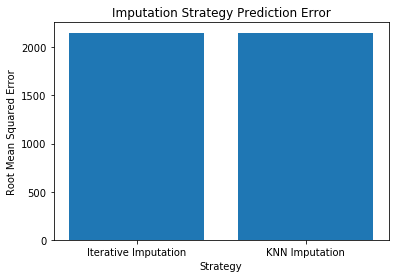

In [75]:
labels = ['Iterative Imputation', 'KNN Imputation']
errors = [np.sqrt(II_RMSE), np.sqrt(KNN_RMSE)]
plt.bar(range(2), errors)
plt.title('Imputation Strategy Prediction Error')
plt.xlabel('Strategy')
plt.ylabel('Root Mean Squared Error')
plt.xticks(range(2), labels)
plt.show()

In [80]:
prom_imputes.remove('price_doc')
df[prom_imputes] = KNNimp.transform(df[prom_imputes])

## Cafe Columns Imputation

The `min`/`max` columns are strongly correlated with the `avg price` column for each catgory (500, 1000, etc).
So we can drop the min/max variables.

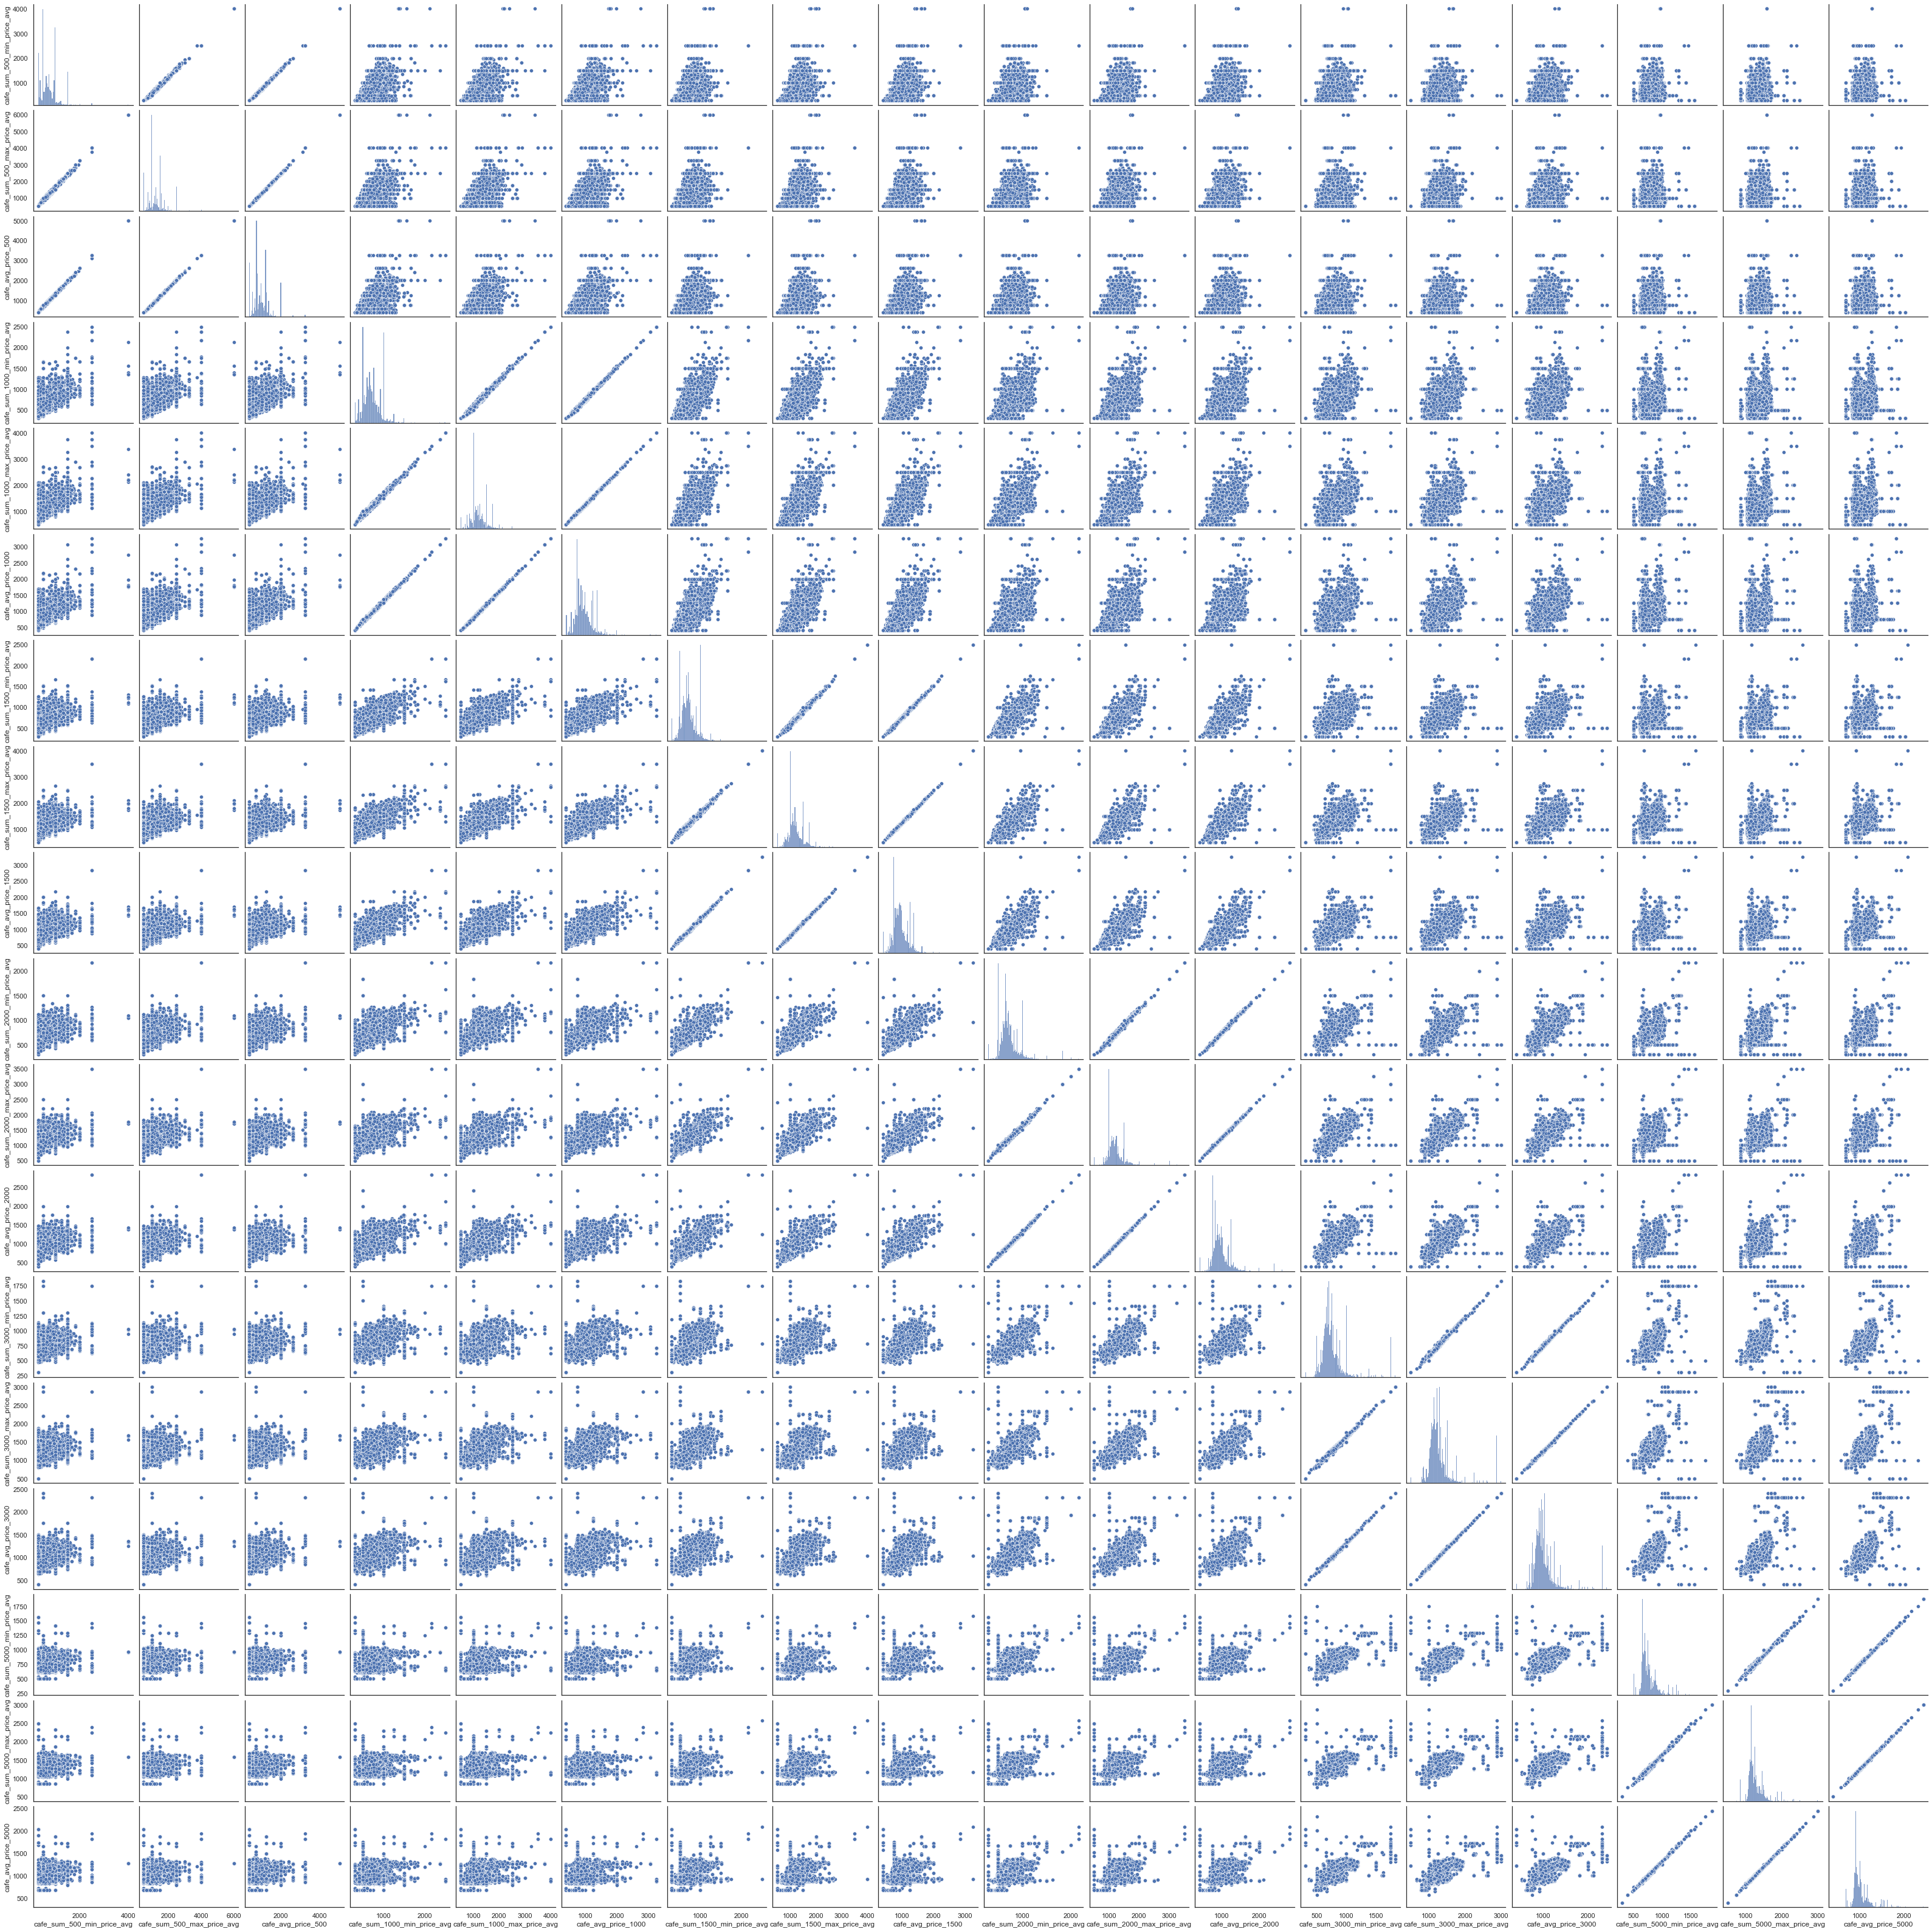

In [237]:
# the min/max columns are strongly correlated with 
# the avg_price column for each catgory (500, 1000, etc)
sns.pairplot(df[['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
                'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
                'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500',
                'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000',
                'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000',
                'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000']])

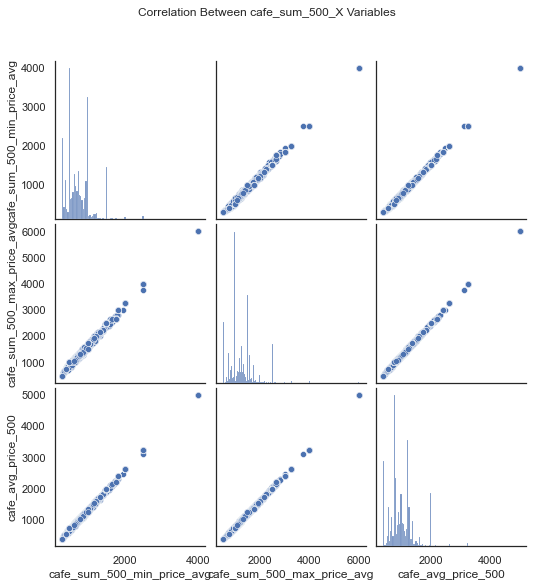

In [238]:
# the min/max columns are strongly correlated with 
# the avg_price column for each catgory (500, 1000, etc)
g = sns.pairplot(df[['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500']])
g.fig.suptitle('Correlation Between cafe_sum_500_X Variables', y=1.08);
g.savefig('./images/cafe_sum_500_X_pairplot.png')

In [239]:
# get all the compete columns
clean_columns = list((df.isna().sum() == 0)[(df.isna().sum() == 0)].index)
# compare a average price column to the complete columns (correlation)
df[clean_columns + ['cafe_avg_price_500']].corr()['cafe_avg_price_500'].sort_values(ascending=False)

cafe_avg_price_500                       1.000000
cafe_count_500_price_2500                0.229900
cafe_count_500_price_4000                0.229842
workplaces_km                            0.210524
cafe_count_500_price_high                0.197076
incineration_km                          0.196380
office_km                                0.182610
cafe_count_5000_price_high               0.174001
cafe_count_5000_price_4000               0.173778
cafe_count_1500_price_high               0.171782
hospice_morgue_km                        0.170448
cafe_count_1000_price_high               0.169934
cafe_count_2000_price_high               0.169910
cafe_count_3000_price_high               0.169393
cafe_count_1000_price_2500               0.166034
cafe_count_3000_price_4000               0.163165
cafe_count_5000_price_2500               0.162795
cafe_count_3000_price_2500               0.160669
ID_bus_terminal                          0.160469
cafe_count_500_price_1500                0.160013


In [240]:
caf_avg_price_cols = ['cafe_avg_price_500', 'cafe_avg_price_1000', 'cafe_avg_price_1500',
                  'cafe_avg_price_2000', 'cafe_avg_price_3000', 'cafe_avg_price_5000']
caf_count_cols = ['cafe_count_500', 'cafe_count_1000', 'cafe_count_1500',
                      'cafe_count_2000', 'cafe_count_3000', 'cafe_count_5000']

cafe_count = defaultdict(list)
missing_percent = defaultdict(list)

# get missing percent of cafe_avg_price_X by value of cafe_count_X
for caf_avg_price_col, caf_count_cal in zip(caf_avg_price_cols, caf_count_cols):
    for i in np.unique(df[caf_count_cal])[0:5]:
        missing_count = df[[caf_avg_price_col, caf_count_cal]].query(caf_count_cal + ' == ' + str(i)).isna().sum()[caf_avg_price_col]
        total_count = df[[caf_avg_price_col, caf_count_cal]].query(caf_count_cal + ' == '  + str(i)).shape[0]
        cafe_count[caf_count_cal].append(i)
        missing_percent[caf_avg_price_col].append(missing_count / total_count)

In [241]:
# get the counts of missing values for cafe_avg_price_500 by cafe_count_500 and sub_area
missing_freq = np.empty((np.unique(df.sub_area).size, 5))
for i, area in enumerate(np.unique(df.sub_area)):
    for j in range(1, 6):
        missing_freq[i,j-1] = df[['cafe_avg_price_500', 'cafe_count_500', 'sub_area']].query("sub_area == " + '"' + area + '"').query("cafe_count_500 == " + str(j)).isna().sum()['cafe_avg_price_500']

The heatmap below shows there is a missingness relationship between cafe count 500 and sub area

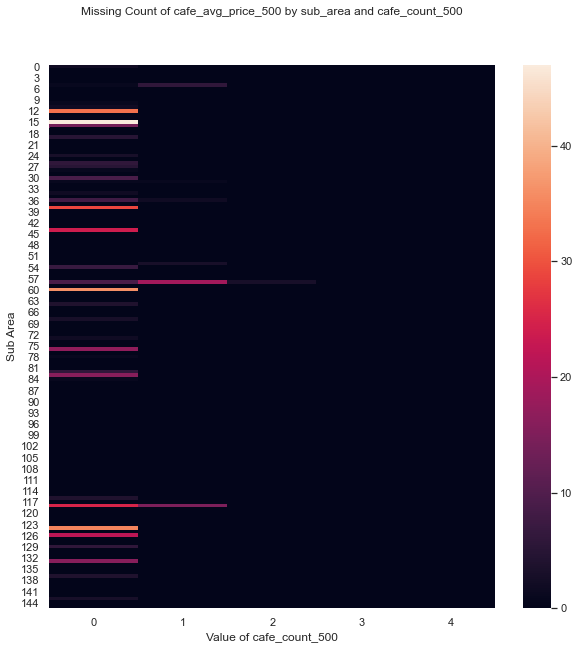

In [242]:
plt.subplots(figsize=(10,10))
g = sns.heatmap(missing_freq)
g.set_title('Missing Count of cafe_avg_price_500 by sub_area and cafe_count_500', y=1.08);
g.set_ylabel('Sub Area')
g.set_xlabel('Value of cafe_count_500');
#plt.savefig('./images/cafe_500_heatmap.png')

For each `cafe_avg_price` variable, there is a corresponding `cafe_count` variable.
When `cafe_count` is 0, the value for `cafe_avg_price` is missing.
Except for when `cafe_count` = 0, the missingness of `cafe_avg_price` appears to be random.
When `cafe_count` is greater than zero, the missingness of `cafe_avg_price` is low, but related to the value of `cafe_count`.
Additionally, the missingness of `cafe_avg_price` appears to be related to `sub_area`

In [243]:
values = list()
print("|", "Sub Area", "|", "Missing Count", "|")
print("|", "-" * 27, "|", "-" * 3, "|", sep='')
for sub_area in np.unique(df.sub_area):
    missing = df.query('sub_area == "' + sub_area + '"')
    missing_count = missing.query('cafe_count_500 != 0')['cafe_avg_price_500'].isna().sum()
    if missing_count > 0:
        values.append(missing.query('cafe_count_500 != 0')['cafe_avg_price_500'].values)
    print("|", f"{sub_area:25s}", "|", f"{missing_count}", "|")

| Sub Area | Missing Count |
|---------------------------|---|
| Ajeroport                 | 2 |
| Akademicheskoe            | 0 |
| Alekseevskoe              | 0 |
| Altuf'evskoe              | 0 |
| Arbat                     | 0 |
| Babushkinskoe             | 7 |
| Basmannoe                 | 0 |
| Begovoe                   | 0 |
| Beskudnikovskoe           | 0 |
| Bibirevo                  | 0 |
| Birjulevo Vostochnoe      | 1 |
| Birjulevo Zapadnoe        | 2 |
| Bogorodskoe               | 33 |
| Brateevo                  | 0 |
| Butyrskoe                 | 0 |
| Caricyno                  | 47 |
| Cheremushki               | 14 |
| Chertanovo Central'noe    | 0 |
| Chertanovo Juzhnoe        | 0 |
| Chertanovo Severnoe       | 5 |
| Danilovskoe               | 0 |
| Dmitrovskoe               | 0 |
| Donskoe                   | 0 |
| Dorogomilovo              | 0 |
| Filevskij Park            | 3 |
| Fili Davydkovo            | 0 |
| Gagarinskoe               | 6 |
| Gol'janovo    

The distributions of cafe_avg_price_X appear to be irregular with outlier.
We will use the median for imputation.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


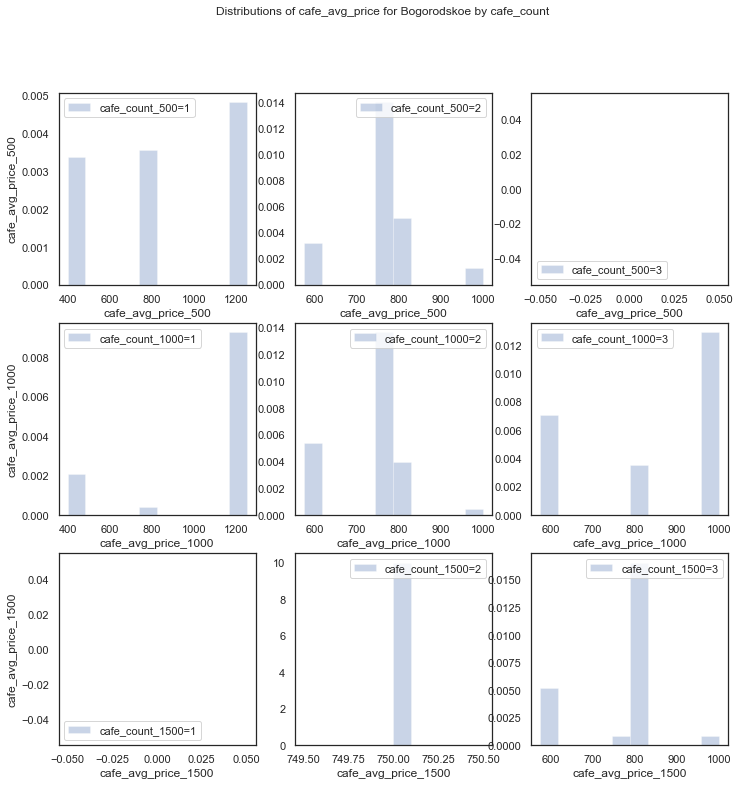

In [244]:
fig, ax = plt.subplots(nrows=len(caf_avg_price_cols[:3]), ncols=3, figsize=(12,12))
fig.suptitle('Distributions of cafe_avg_price for Bogorodskoe by cafe_count')
for i, caf_avg_price_col, caf_count_cal in zip([k for k in range(len(caf_avg_price_cols))][:3], caf_avg_price_cols[:3], caf_count_cols[:3]):
    
    #ax[i].set_title('Distribution of ' + caf_avg_price_col + ' Conditioned on ' + caf_count_cal)
    for j in np.unique(df[caf_count_cal])[1:4]:
        ax[i,j-1].hist(df.query(caf_count_cal + ' == ' + str(j)).query('sub_area == "Bogorodskoe"')[caf_avg_price_col],
                   label=caf_count_cal + '=' + str(j), alpha=0.3, density=True)
        ax[i,j-1].legend();
        ax[i,j-1].set_xlabel(caf_avg_price_col)
        if j-1 == 0:
            ax[i,j-1].set_ylabel(caf_avg_price_col)
fig.savefig('./images/distributions_of_caf_avg_price_col.png')

In [ ]:
for caf_avg_price_col, caf_count_col in zip(caf_avg_price_cols, caf_count_cols):
    # print just to see it running
    print(caf_avg_price_col)
    for i in np.unique(df[caf_count_col]):
        for sub_area in np.unique(df.sub_area):
            idxes = df.query('sub_area == ' + '"' + sub_area + '"')[df[caf_avg_price_col].isna() & (df[caf_count_col]==i)][caf_avg_price_col].index
            # when value of count col is 0 set avg col to -1
            if i == 0:
                df.loc[idxes, caf_avg_price_col] = -1
            else: # else use the median ignoring the nans
                if np.all(np.isnan(df[df[caf_count_col]==i][caf_avg_price_col])):
                    df.loc[idxes, caf_avg_price_col] = -1
                else:
                    df.loc[idxes, caf_avg_price_col] = np.nanmedian(df[df[caf_count_col]==i][caf_avg_price_col])

# drop the collinear columns
cafe_min_max_cols = ['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
                     'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg',
                     'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
                     'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
                     'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                     'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg',]
            
df = df.drop(cafe_min_max_cols, axis=1)